In [515]:
import os
import torch
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import data_cleaning as dc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

# Real Estate Price Challenge 
The aim of this notebook is to create a model that is tries to outperform the model created using SalesForce Predictions. For reference, the two main KPI that will used to measure the model's performance are: 
- R2 score 
- Mean Absolute Error (MAE) 

These measures are observed over a validation set (seperated from the training set). 

Here is a rapid table that summarized SF's model's performance:  

| Model   |      R2      |  RMSE |
|----------|-------------|------|
| GLM |  0.84 | 33270 |
| XGBoost |    0.82   |   32186 |

SalesForce has the ability to create model only on at most 13 features. The features selected by SF will be compared with the ones selected by the created model. Here is the exhaustive list of features selected by SF (in order of importance): 
1. Neighborhood
2. GarageCars
3. ExterQual
4. GrLicArea
5. BsmtQual
6. KitchenQual
7. GarageArea
8. TotalBsmtSF
9. AstFlrSF
10. YearBuit
12. GarageFinish

Some key observations can be made on the features selected by SF: as expected key features were selected such as the neighborhood, the construction year or the ground living area. These features are expected to play a key role in the final price a house sold. However, some features that one may think to be important such as the overall quality of the listing (OvrlQuality), the year the house was sold, or some key amenities such as if the house offers a pool, A/C have been omitted by SF model. 

# I. Data Pre-processing
First, the data is loaded and nan columns are removed. Some key insights about the dataset are explored in this part, such as the feature correlation heatmap, the correlation between features and target (i.e SalePrice). 

In [462]:
# load the dataset and define the target
df = pd.read_csv('real_estate_price.csv')
target = "SalePrice"

# columns to delete (either because they represent ID feature, or because they contain lots of nan's in them
id_columns = ["Id", "Street", "Alley"]
unused_columns = [ "PoolQC", "Fence", "MiscFeature", "FireplaceQu", "LotFrontage"] #"GarageQual", "GarageCond", 
df.drop(columns=id_columns + unused_columns, inplace=True)

# take care of non-value 
df = df.dropna(how='any')
df = df.reset_index(drop=True)

#dc.draw_heatmap(df, df.columns, figsize_=15)

<AxesSubplot:xlabel='SalePrice', ylabel='index'>

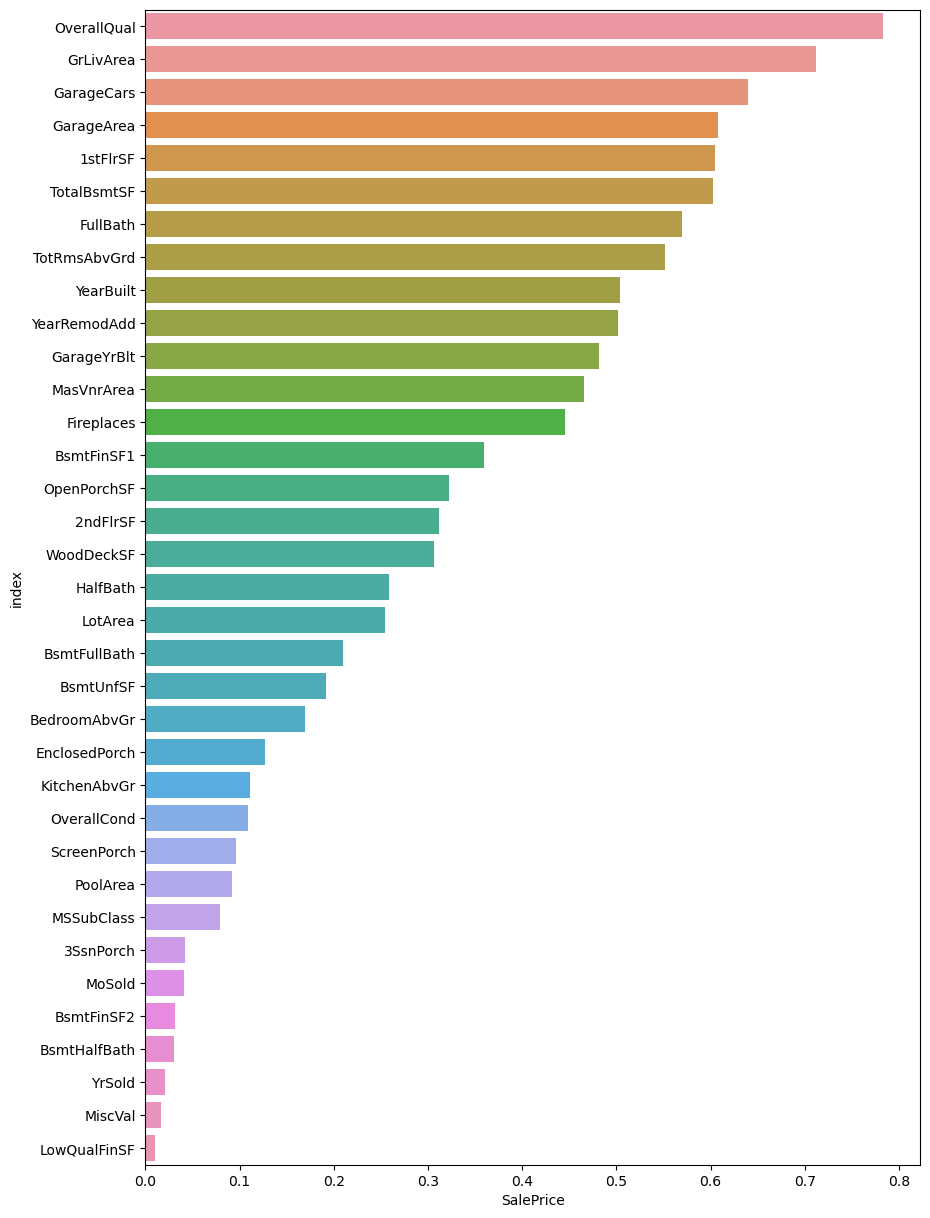

In [226]:
# correlation with Salesprice (first 20)
fig, ax = plt.subplots(figsize=(10, 15))

# computation of the correlation with target, will be used later 
correlations = df.corr()["SalePrice"].reset_index()
correlations["SalePrice"] = np.abs(correlations["SalePrice"])
correlations = correlations.sort_values(["SalePrice"], ascending=False).reset_index(drop=True)
sns.barplot(ax=ax, y="index", x="SalePrice", data=correlations[1:40], orient="h")

In [ ]:
# some insights on how well the neighboord explains SalePrice (according to SF most strongly correlated feature)
sns.barplot(y="Neighborhood", x="SalePrice", data=df, orient="h")

## II. TabNet Brute Force
To beat SF's model, a TabNet model is used. The main downsize of TabNet compared to GLM or XGBoost regression trees is that the hyper-paramters of neural networks need to be carefully tuned. 
However, once the set of hyper-parameters is set, TabNet model to reach better performances, without over-fitting (like regression trees can). 

In [482]:
# define the training, testing and validation set
if "Set" not in df.columns:
    df["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(df.shape[0],))

train_indices = df[df.Set=="train"].index
valid_indices = df[df.Set=="valid"].index
test_indices = df[df.Set=="test"].index

In [483]:
# find the categorical columns
nunique = df.nunique()
types = df.dtypes

categorical_columns = []
categorical_dims =  {}
for col in df.columns:
    if types[col] == 'object' or nunique[col] < 200:
        l_enc = LabelEncoder()
        df[col] = df[col].fillna("VV_likely")
        df[col] = l_enc.fit_transform(df[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        df.fillna(df.loc[train_indices, col].mean(), inplace=True)

In [484]:
# define the features to use, for the first set of predictions all features are used 
unused_feat = ['Set']
features = [ col for col in df.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [540]:
# extract the training, testing and validation set 
X_train = df[features].values[train_indices]
y_train = df[target].values[train_indices].reshape(-1, 1)

X_valid = df[features].values[valid_indices]
y_valid = df[target].values[valid_indices].reshape(-1, 1)

X_test = df[features].values[test_indices]
y_test = df[target].values[test_indices].reshape(-1, 1)

In [486]:
# define TabNet model
# high learning rate for faster converhance, reduced spare_parameter to get a model that selects
# a comprehensive set of features
max_epochs = 2000 if not os.getenv("CI", False) else 2
clf = TabNetRegressor(n_d=15, n_a=15,
                      cat_dims=cat_dims, 
                      cat_idxs=cat_idxs, 
                      cat_emb_dim=1, 
                      optimizer_fn=torch.optim.Adam,
                      optimizer_params=dict(lr=0.5),
                      lambda_sparse=1e-4,
                      n_steps=6,
                      #scheduler_params={"step_size":125, "gamma":0.5},
                     )

Device used : cpu


In [487]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'],
    max_epochs=max_epochs,
    patience=300,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

epoch 0  | loss: 40442283071.09005| train_rmse: 199190.28048| valid_rmse: 206090.69443|  0:00:00s
epoch 1  | loss: 40417912038.03602| train_rmse: 197504.89862| valid_rmse: 204325.36394|  0:00:00s
epoch 2  | loss: 40354261207.47678| train_rmse: 191376.40126| valid_rmse: 198103.51799|  0:00:01s
epoch 3  | loss: 40252708170.9801| train_rmse: 194365.22207| valid_rmse: 201360.34217|  0:00:01s
epoch 4  | loss: 40093663204.82274| train_rmse: 195986.35048| valid_rmse: 202479.41653|  0:00:02s
epoch 5  | loss: 39911975077.00474| train_rmse: 194828.04846| valid_rmse: 201369.75967|  0:00:02s
epoch 6  | loss: 39684855243.10142| train_rmse: 193931.84835| valid_rmse: 200371.66575|  0:00:03s
epoch 7  | loss: 39378338222.95355| train_rmse: 192644.18737| valid_rmse: 199032.64432|  0:00:03s
epoch 8  | loss: 39037931593.76682| train_rmse: 191756.38088| valid_rmse: 198188.72046|  0:00:03s
epoch 9  | loss: 38576538419.2| train_rmse: 190925.56863| valid_rmse: 197576.40288|  0:00:04s
epoch 10 | loss: 38091325

epoch 86 | loss: 1647402692.36777| train_rmse: 49667.10393| valid_rmse: 47989.15266|  0:00:47s
epoch 87 | loss: 1550702715.75355| train_rmse: 50711.68686| valid_rmse: 49324.39557|  0:00:48s
epoch 88 | loss: 1490637206.68815| train_rmse: 53278.95577| valid_rmse: 52813.06649|  0:00:48s
epoch 89 | loss: 1533020400.7128| train_rmse: 54296.61181| valid_rmse: 53875.56673|  0:00:49s
epoch 90 | loss: 1485742402.85118| train_rmse: 51956.75479| valid_rmse: 53892.97672|  0:00:50s
epoch 91 | loss: 1540441658.72227| train_rmse: 51103.12994| valid_rmse: 52851.65479|  0:00:51s
epoch 92 | loss: 1654975226.41896| train_rmse: 51475.02522| valid_rmse: 55124.24321|  0:00:51s
epoch 93 | loss: 1629814186.70711| train_rmse: 52731.39026| valid_rmse: 55100.22405|  0:00:52s
epoch 94 | loss: 1616958034.50237| train_rmse: 49527.20191| valid_rmse: 54078.07334|  0:00:53s
epoch 95 | loss: 1690785032.9782| train_rmse: 48386.71152| valid_rmse: 52987.08783|  0:00:54s
epoch 96 | loss: 1751007890.25972| train_rmse: 47501

epoch 173| loss: 1371679728.47014| train_rmse: 39608.64664| valid_rmse: 38847.27803|  0:01:43s
epoch 174| loss: 1386347598.1346| train_rmse: 39483.32195| valid_rmse: 39354.02179|  0:01:43s
epoch 175| loss: 1524753664.24265| train_rmse: 38817.16104| valid_rmse: 39886.28142|  0:01:44s
epoch 176| loss: 1480400368.22749| train_rmse: 38591.64669| valid_rmse: 39621.63769|  0:01:44s
epoch 177| loss: 1424087311.16588| train_rmse: 39043.18489| valid_rmse: 40628.3345|  0:01:45s
epoch 178| loss: 1476437032.64455| train_rmse: 41267.06374| valid_rmse: 40559.03861|  0:01:45s
epoch 179| loss: 1434533305.08436| train_rmse: 45417.95426| valid_rmse: 42487.38697|  0:01:46s
epoch 180| loss: 1545867041.00095| train_rmse: 50837.92136| valid_rmse: 48232.97778|  0:01:47s
epoch 181| loss: 1490083182.16493| train_rmse: 53567.01485| valid_rmse: 53121.48048|  0:01:47s
epoch 182| loss: 1499646336.84929| train_rmse: 54147.70577| valid_rmse: 53343.87812|  0:01:48s
epoch 183| loss: 1515556106.91943| train_rmse: 56817

epoch 260| loss: 1488898105.14502| train_rmse: 55045.00332| valid_rmse: 57558.2646|  0:02:36s
epoch 261| loss: 1500712538.50995| train_rmse: 60429.36408| valid_rmse: 59102.12062|  0:02:36s
epoch 262| loss: 1502696057.0237| train_rmse: 57419.71161| valid_rmse: 55448.61673|  0:02:37s
epoch 263| loss: 1519536152.75071| train_rmse: 57732.0911| valid_rmse: 57116.44718|  0:02:38s
epoch 264| loss: 1482358562.09289| train_rmse: 61376.79752| valid_rmse: 60936.6774|  0:02:38s
epoch 265| loss: 1424835197.69479| train_rmse: 62737.57456| valid_rmse: 64496.29652|  0:02:39s
epoch 266| loss: 1508407831.29479| train_rmse: 63745.53926| valid_rmse: 65250.38186|  0:02:39s
epoch 267| loss: 1638622338.30521| train_rmse: 64198.53075| valid_rmse: 65987.03056|  0:02:40s
epoch 268| loss: 1578290128.92512| train_rmse: 64166.84517| valid_rmse: 68438.74844|  0:02:41s
epoch 269| loss: 1465406611.7763| train_rmse: 58921.87021| valid_rmse: 61952.47164|  0:02:41s
epoch 270| loss: 1405193237.83886| train_rmse: 62260.52

epoch 347| loss: 1385243277.64929| train_rmse: 39222.15693| valid_rmse: 42913.37433|  0:03:27s
epoch 348| loss: 1361842745.38768| train_rmse: 39826.21301| valid_rmse: 43553.05891|  0:03:28s
epoch 349| loss: 1331140145.25877| train_rmse: 38142.28677| valid_rmse: 41790.78354|  0:03:29s
epoch 350| loss: 1363750754.94218| train_rmse: 37612.57858| valid_rmse: 41750.66083|  0:03:29s
epoch 351| loss: 1313888817.31943| train_rmse: 37790.61397| valid_rmse: 43815.31244|  0:03:30s
epoch 352| loss: 1278594843.54123| train_rmse: 38447.81175| valid_rmse: 45699.31248|  0:03:30s
epoch 353| loss: 1321403738.69194| train_rmse: 38561.028| valid_rmse: 45856.97247|  0:03:31s
epoch 354| loss: 1397326945.18294| train_rmse: 40361.01056| valid_rmse: 43749.48432|  0:03:32s
epoch 355| loss: 1348850286.46825| train_rmse: 42840.81225| valid_rmse: 43897.96076|  0:03:32s
epoch 356| loss: 1528467443.38199| train_rmse: 44892.79222| valid_rmse: 45651.6401|  0:03:33s
epoch 357| loss: 1514337627.11659| train_rmse: 44738.

epoch 434| loss: 1042673190.09668| train_rmse: 32672.89451| valid_rmse: 37175.51378|  0:04:24s
epoch 435| loss: 1008287508.98957| train_rmse: 32735.98877| valid_rmse: 36958.23375|  0:04:24s
epoch 436| loss: 978801206.77915| train_rmse: 31616.68197| valid_rmse: 36781.713|  0:04:25s
epoch 437| loss: 992378722.27488| train_rmse: 32340.36246| valid_rmse: 37225.52156|  0:04:25s
epoch 438| loss: 1000822354.50237| train_rmse: 32928.49588| valid_rmse: 38172.31045|  0:04:26s
epoch 439| loss: 1034738596.27678| train_rmse: 32966.20821| valid_rmse: 37607.78771|  0:04:27s
epoch 440| loss: 1218806708.5346| train_rmse: 33164.1679| valid_rmse: 37327.38978|  0:04:27s
epoch 441| loss: 1201577837.67962| train_rmse: 34405.77434| valid_rmse: 38913.281|  0:04:28s
epoch 442| loss: 1356962799.3782| train_rmse: 35865.27822| valid_rmse: 40870.7142|  0:04:28s
epoch 443| loss: 1313575102.72607| train_rmse: 43889.3769| valid_rmse: 48132.60031|  0:04:29s
epoch 444| loss: 1197858306.18389| train_rmse: 42439.77232| v

epoch 521| loss: 1188407827.16967| train_rmse: 36869.13726| valid_rmse: 40358.9416|  0:05:19s
epoch 522| loss: 1170456945.25877| train_rmse: 40028.78683| valid_rmse: 44514.94507|  0:05:20s
epoch 523| loss: 1231434155.19242| train_rmse: 39958.1839| valid_rmse: 44568.07712|  0:05:20s
epoch 524| loss: 1008225733.09573| train_rmse: 39038.25477| valid_rmse: 43715.25665|  0:05:21s
epoch 525| loss: 901765997.92227| train_rmse: 39259.66862| valid_rmse: 44273.05685|  0:05:22s
epoch 526| loss: 1165408659.71564| train_rmse: 39542.99515| valid_rmse: 45140.63783|  0:05:22s
epoch 527| loss: 1163138299.38957| train_rmse: 38945.76738| valid_rmse: 44764.4123|  0:05:23s
epoch 528| loss: 1096378008.2654| train_rmse: 39227.65938| valid_rmse: 44700.42952|  0:05:23s
epoch 529| loss: 1074675674.63128| train_rmse: 41617.94767| valid_rmse: 45776.92697|  0:05:24s
epoch 530| loss: 1121313154.79052| train_rmse: 45715.31969| valid_rmse: 47381.24488|  0:05:25s
epoch 531| loss: 1203066090.2218| train_rmse: 43502.084

epoch 608| loss: 913553043.7763| train_rmse: 34973.17682| valid_rmse: 34685.91124|  0:06:15s
epoch 609| loss: 925813128.85687| train_rmse: 33874.97961| valid_rmse: 34279.42604|  0:06:16s
epoch 610| loss: 906354390.59716| train_rmse: 33599.99537| valid_rmse: 34281.93452|  0:06:17s
epoch 611| loss: 895321737.76682| train_rmse: 33697.23583| valid_rmse: 34694.75792|  0:06:17s
epoch 612| loss: 866365522.68436| train_rmse: 33857.2277| valid_rmse: 34705.16773|  0:06:18s
epoch 613| loss: 874526013.93744| train_rmse: 34582.21094| valid_rmse: 35107.6713|  0:06:19s
epoch 614| loss: 864522256.98578| train_rmse: 35439.53725| valid_rmse: 34641.94209|  0:06:20s
epoch 615| loss: 922289814.20284| train_rmse: 36505.64774| valid_rmse: 36673.90233|  0:06:20s
epoch 616| loss: 907571881.61517| train_rmse: 38603.92214| valid_rmse: 40894.18736|  0:06:21s
epoch 617| loss: 922499616.43981| train_rmse: 35519.31783| valid_rmse: 37337.46339|  0:06:22s
epoch 618| loss: 876087635.41232| train_rmse: 38437.48132| vali

epoch 696| loss: 848423567.34787| train_rmse: 65023.53369| valid_rmse: 70051.15951|  0:07:12s
epoch 697| loss: 750689304.9327| train_rmse: 66349.20765| valid_rmse: 71395.26393|  0:07:13s
epoch 698| loss: 740230651.57156| train_rmse: 66713.60876| valid_rmse: 70833.31818|  0:07:13s
epoch 699| loss: 727430747.93554| train_rmse: 66193.99682| valid_rmse: 70614.51957|  0:07:14s
epoch 700| loss: 759009713.01611| train_rmse: 62325.44827| valid_rmse: 66940.34389|  0:07:15s
epoch 701| loss: 758273503.60569| train_rmse: 56787.97844| valid_rmse: 61934.41448|  0:07:15s
epoch 702| loss: 730718611.53365| train_rmse: 50472.69673| valid_rmse: 54448.96758|  0:07:16s
epoch 703| loss: 942850387.83697| train_rmse: 44630.32363| valid_rmse: 48319.14834|  0:07:17s
epoch 704| loss: 828793515.73839| train_rmse: 44803.29124| valid_rmse: 48376.67279|  0:07:17s
epoch 705| loss: 748558842.29763| train_rmse: 48067.63346| valid_rmse: 52850.33829|  0:07:18s
epoch 706| loss: 746333884.72417| train_rmse: 52457.8237| val

epoch 784| loss: 718124210.04739| train_rmse: 40193.16813| valid_rmse: 44493.1506|  0:08:09s
epoch 785| loss: 718636485.21706| train_rmse: 41486.78971| valid_rmse: 46396.13981|  0:08:09s
epoch 786| loss: 798068538.96493| train_rmse: 34722.05622| valid_rmse: 40400.45377|  0:08:10s
epoch 787| loss: 760794879.75735| train_rmse: 33424.6097| valid_rmse: 38480.20291|  0:08:11s
epoch 788| loss: 760735163.20758| train_rmse: 33269.21983| valid_rmse: 38384.80237|  0:08:11s
epoch 789| loss: 821017055.36303| train_rmse: 30966.29697| valid_rmse: 36304.93323|  0:08:12s
epoch 790| loss: 758573157.91469| train_rmse: 28946.77375| valid_rmse: 33904.94029|  0:08:13s
epoch 791| loss: 728592286.45308| train_rmse: 32737.81132| valid_rmse: 38835.77772|  0:08:13s
epoch 792| loss: 699833826.94218| train_rmse: 32792.95939| valid_rmse: 38463.69832|  0:08:14s
epoch 793| loss: 752929434.38863| train_rmse: 34209.12818| valid_rmse: 38963.35755|  0:08:14s
epoch 794| loss: 750774672.19716| train_rmse: 36292.79551| val

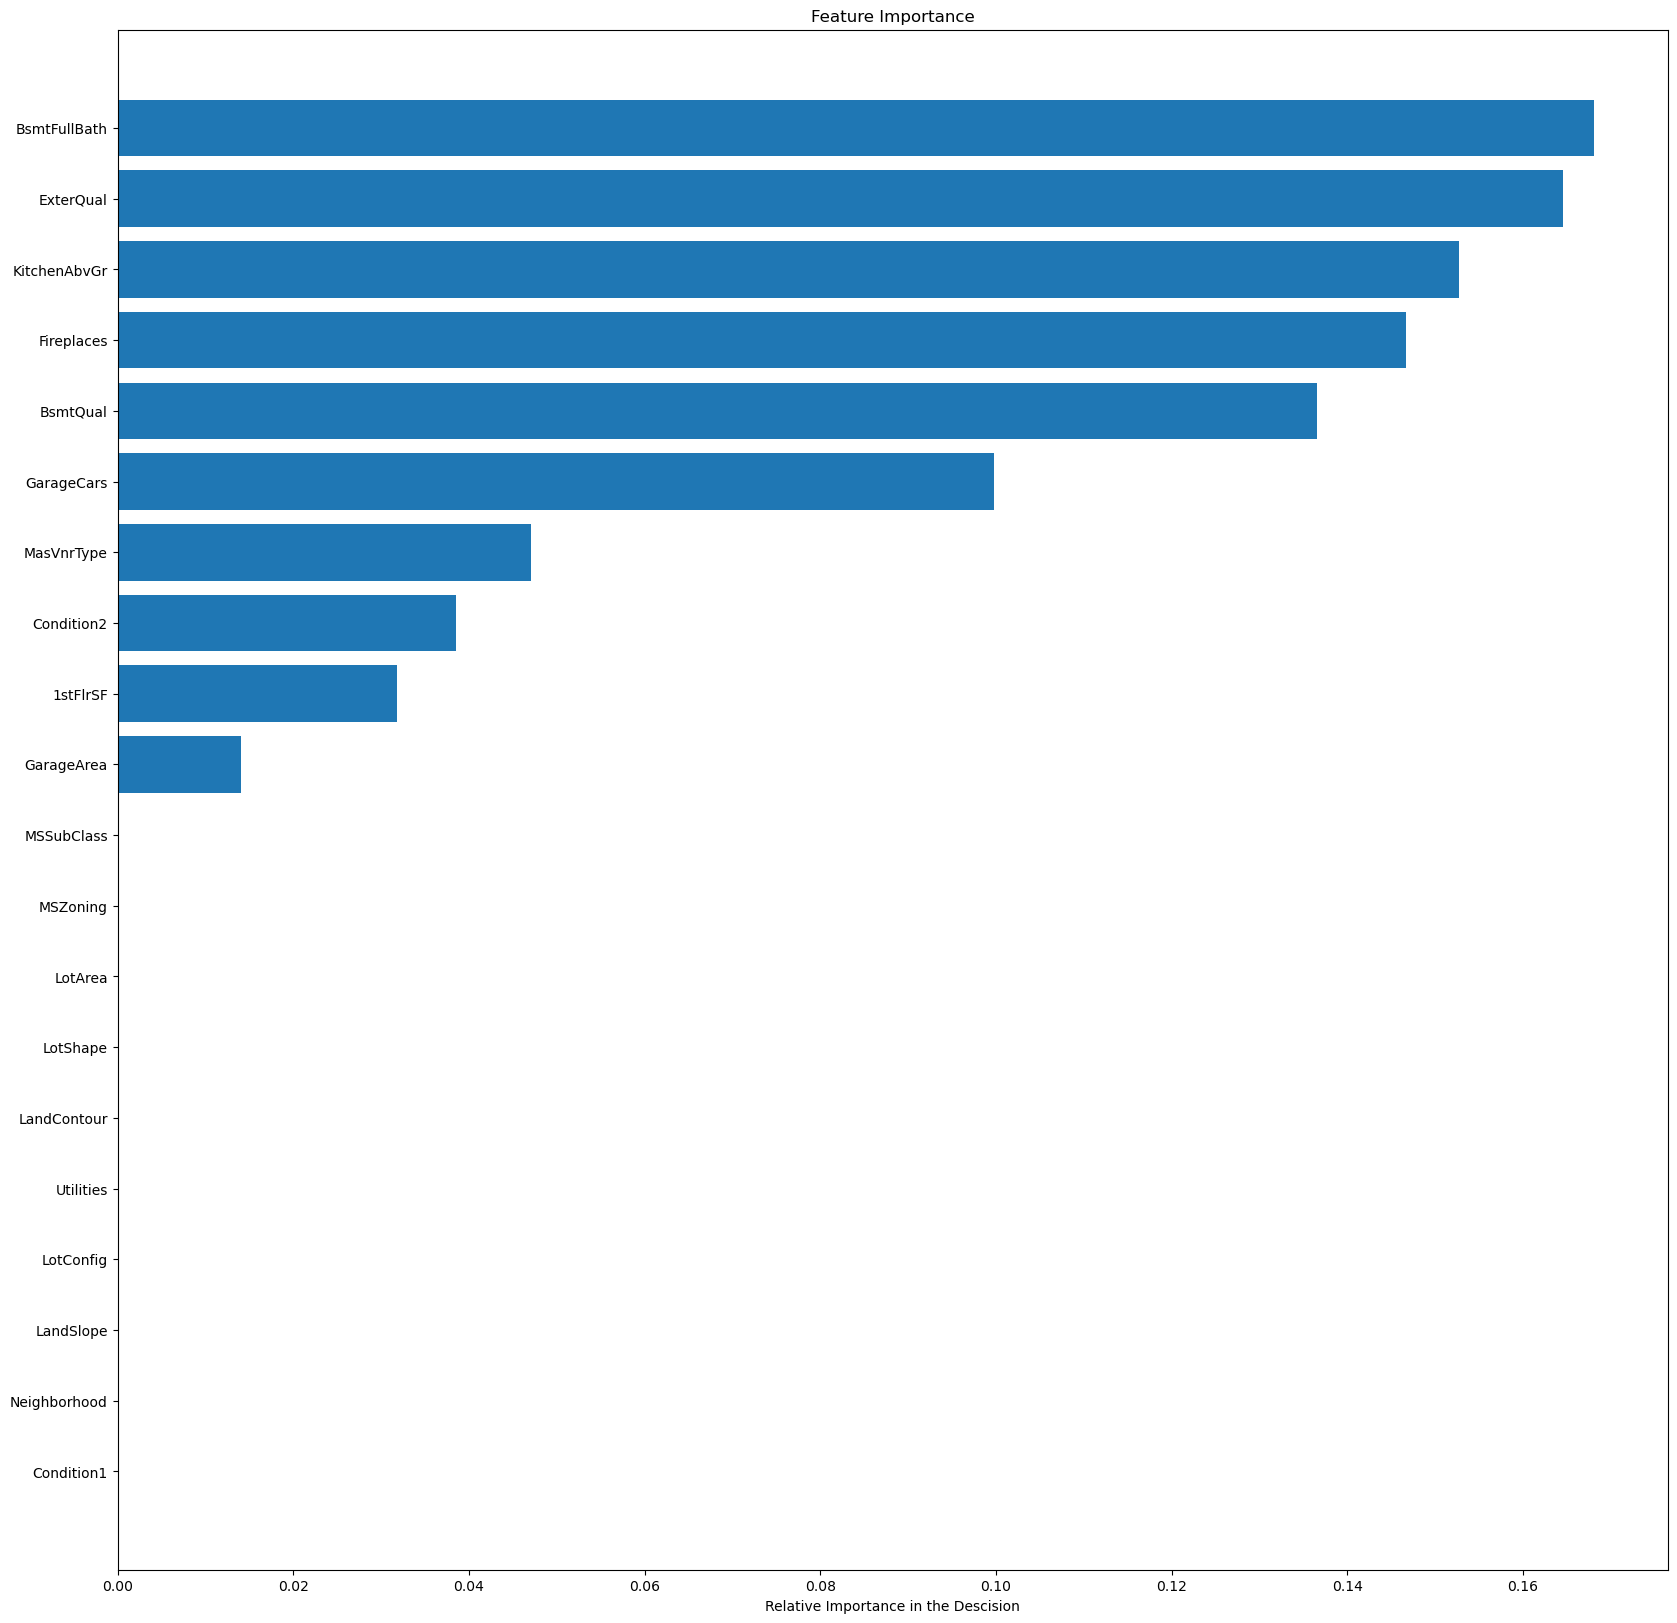

In [488]:
n_most_important = 20

dict_feature_importance = dict(zip(features, clf.feature_importances_))
dict_feature_importance = {k: v for k, v in sorted(dict_feature_importance.items(), key=lambda item: item[1], reverse=True)}

fig, ax = plt.subplots()

y_pos = np.arange(len(features))

ax.barh(y_pos[:n_most_important], list(dict_feature_importance.values())[:n_most_important], align='center')
ax.set_yticks(y_pos[:n_most_important])
ax.set_yticklabels(list(dict_feature_importance.keys())[:n_most_important])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Relative Importance in the Descision')
ax.set_title('Feature Importance')

plt.show()

In [489]:
# compute the R2 scre
r2_score(y_valid.flatten(), clf.predict(X_valid).flatten())

0.8509613874197104

The final performance of the model are: 
- **R2: 0.85**
- **RMSE: 32251**   

So without any feature selection method, the model is able to already reach SF performances. However, when looking at the features selected by SF, one may think they do not represent well how a price should be defined. According to the model, the categorical features BsmtFullBath is the most relevant features to predict the sale's price, which is strange to say the least...   
Some feature selection must be applied to encourage the model to find an optimal solution on a smaller field's space. 

## III. TabNet with only the top 40 features correlated to the sale's price
Eventhough one of the virtue of TabNet is its ability to select relevant features to make final predictions, a little help is provided to the training process by only giving the top 40 features features correlated to the sale's price. 

In [490]:
# we will try tabnet with different feature combinations, hence we create a function to train a model, 
# just by giving feature list to use

def train_tabnet(data, features, lr=0.5, max_epochs=100, lambda_sparse=1e-5, n_steps=7): 
    df = data.copy()
    
    df["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(df.shape[0],))

    train_indices = df[df.Set=="train"].index
    valid_indices = df[df.Set=="valid"].index
    test_indices = df[df.Set=="test"].index
    
    
    # detect dimensions columns and encode them
    nunique = df.nunique()
    types = df.dtypes
    categorical_columns = []
    categorical_dims =  {}
    for col in df.columns:
        if types[col] == 'object' or nunique[col] < 200:
            l_enc = LabelEncoder()
            df[col] = df[col].fillna("VV_likely")
            df[col] = l_enc.fit_transform(df[col].values)
            categorical_columns.append(col)
            categorical_dims[col] = len(l_enc.classes_)
        else:
            df.fillna(df.loc[train_indices, col].mean(), inplace=True)
    
    # create the dimensions for training 
    unused_feat = ['Set']
    cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
    cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
    
    # get the training, validation and testing data
    X_train = df[features].values[train_indices]
    y_train = df[target].values[train_indices].reshape(-1, 1)
    X_valid = df[features].values[valid_indices]
    y_valid = df[target].values[valid_indices].reshape(-1, 1)
    X_test = df[features].values[test_indices]
    y_test = df[target].values[test_indices].reshape(-1, 1)
    
    # configure the model
    clf = TabNetRegressor(
                      n_d=15, n_a=15,
                      cat_dims=cat_dims, 
                      cat_idxs=cat_idxs, 
                      cat_emb_dim=1, 
                      optimizer_fn=torch.optim.Adam,
                      optimizer_params=dict(lr=lr),
                      lambda_sparse=lambda_sparse,
                      n_steps=7,
                      #scheduler_params={"step_size":75, "gamma":0.9},
                    )
    
    # train the model
    max_epochs_ = max_epochs if not os.getenv("CI", False) else 2
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['rmse'],
        max_epochs=max_epochs,
        patience=500,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )
    
    print("Best MAE on validation: {:.2f}".format(clf.best_cost))
    return clf, X_train, y_train, X_valid, y_valid, X_test, y_test

In [562]:
data = pd.read_csv('real_estate_price.csv')

target = "SalePrice"

# columns to delete 
id_columns = ["Id", "Street", "Alley"]
unused_columns = [ "PoolQC", "Fence", "MiscFeature", "FireplaceQu", "LotFrontage"] #"GarageQual", "GarageCond", 
data.drop(columns=id_columns + unused_columns, inplace=True)

# take care of non-value 
data = df.dropna(how='any')
data = data.reset_index(drop=True)

#dc.draw_heatmap(df, df.columns, figsize_=15)

In [502]:
clf_corr, X_train, y_train, X_valid, y_valid, X_test, y_test = train_tabnet(data, correlations["index"][1:40], 
                                                                            max_epochs=1000, lr=2e-1, lambda_sparse=1e-5, 
                                                                            n_steps=7)

Device used : cpu
epoch 0  | loss: 41381016564.49438| train_rmse: 202511.30624| valid_rmse: 207020.28279|  0:00:00s
epoch 1  | loss: 41366223223.85019| train_rmse: 201652.49516| valid_rmse: 206160.65278|  0:00:00s
epoch 2  | loss: 41344163886.02247| train_rmse: 201837.34192| valid_rmse: 206309.76519|  0:00:01s
epoch 3  | loss: 41311150962.09738| train_rmse: 201007.60628| valid_rmse: 205251.27168|  0:00:01s
epoch 4  | loss: 41261656485.87266| train_rmse: 199350.17052| valid_rmse: 203438.33533|  0:00:01s
epoch 5  | loss: 41194220816.29963| train_rmse: 195911.93444| valid_rmse: 200368.90658|  0:00:02s
epoch 6  | loss: 41112713699.23596| train_rmse: 194925.01858| valid_rmse: 199547.35177|  0:00:02s
epoch 7  | loss: 41009036192.11985| train_rmse: 195734.62567| valid_rmse: 199983.02407|  0:00:03s
epoch 8  | loss: 40876721355.26592| train_rmse: 194930.90362| valid_rmse: 199393.8031|  0:00:03s
epoch 9  | loss: 40728029084.28464| train_rmse: 193724.08559| valid_rmse: 198042.51489|  0:00:03s
epo

epoch 85 | loss: 1236086706.09738| train_rmse: 70095.22382| valid_rmse: 71555.02531|  0:00:37s
epoch 86 | loss: 1225854112.11985| train_rmse: 68639.80208| valid_rmse: 70271.86136|  0:00:37s
epoch 87 | loss: 1251549691.20599| train_rmse: 66079.03535| valid_rmse: 68662.88426|  0:00:37s
epoch 88 | loss: 1264165869.06367| train_rmse: 63001.28162| valid_rmse: 63488.87564|  0:00:38s
epoch 89 | loss: 1315187236.67416| train_rmse: 59024.18462| valid_rmse: 59978.3111|  0:00:38s
epoch 90 | loss: 1259998653.8427| train_rmse: 49857.37764| valid_rmse: 51383.03504|  0:00:39s
epoch 91 | loss: 1238335245.42322| train_rmse: 44409.90727| valid_rmse: 46817.05898|  0:00:39s
epoch 92 | loss: 1386296002.6367| train_rmse: 46399.75966| valid_rmse: 47080.0747|  0:00:40s
epoch 93 | loss: 1297266333.24345| train_rmse: 47478.99053| valid_rmse: 47052.98211|  0:00:40s
epoch 94 | loss: 1413601176.92884| train_rmse: 48300.77911| valid_rmse: 46300.21255|  0:00:41s
epoch 95 | loss: 1479226624.7191| train_rmse: 42371.14

epoch 172| loss: 1091363799.73034| train_rmse: 33951.02043| valid_rmse: 33006.87921|  0:01:16s
epoch 173| loss: 1149483645.603| train_rmse: 35725.35105| valid_rmse: 35564.91569|  0:01:17s
epoch 174| loss: 1165140606.3221| train_rmse: 38718.05382| valid_rmse: 38762.9803|  0:01:17s
epoch 175| loss: 1012536823.61049| train_rmse: 40264.55605| valid_rmse: 40175.13335|  0:01:18s
epoch 176| loss: 1005821101.78277| train_rmse: 40459.91592| valid_rmse: 40180.13134|  0:01:18s
epoch 177| loss: 1150747066.00749| train_rmse: 39537.96678| valid_rmse: 38914.27159|  0:01:18s
epoch 178| loss: 1013403886.98127| train_rmse: 37376.04252| valid_rmse: 36720.67689|  0:01:19s
epoch 179| loss: 981759848.26966| train_rmse: 34824.97653| valid_rmse: 34242.015|  0:01:19s
epoch 180| loss: 937161617.73783| train_rmse: 32833.1174| valid_rmse: 33377.62606|  0:01:20s
epoch 181| loss: 960186900.13483| train_rmse: 32448.18834| valid_rmse: 32185.72122|  0:01:20s
epoch 182| loss: 998129870.62172| train_rmse: 32646.5987| va

epoch 259| loss: 1014117830.95131| train_rmse: 35457.24132| valid_rmse: 37224.12929|  0:01:58s
epoch 260| loss: 1156473682.21723| train_rmse: 37255.93534| valid_rmse: 39073.66673|  0:01:58s
epoch 261| loss: 1045817036.22472| train_rmse: 37029.34532| valid_rmse: 40133.8622|  0:01:59s
epoch 262| loss: 1068555710.8015| train_rmse: 36203.88239| valid_rmse: 40066.20917|  0:01:59s
epoch 263| loss: 980291446.17228| train_rmse: 35759.31134| valid_rmse: 40134.62103|  0:02:00s
epoch 264| loss: 977420150.89139| train_rmse: 34769.49669| valid_rmse: 38421.25319|  0:02:00s
epoch 265| loss: 931633954.51685| train_rmse: 34261.27351| valid_rmse: 37839.0891|  0:02:01s
epoch 266| loss: 997560339.89513| train_rmse: 32736.02408| valid_rmse: 34678.81359|  0:02:01s
epoch 267| loss: 914423017.22846| train_rmse: 29106.19194| valid_rmse: 31394.79759|  0:02:01s
epoch 268| loss: 938925874.57678| train_rmse: 34254.65718| valid_rmse: 33129.25509|  0:02:02s
epoch 269| loss: 1079019163.80524| train_rmse: 39092.58355|

epoch 347| loss: 791761653.93258| train_rmse: 29017.17558| valid_rmse: 34056.41886|  0:02:39s
epoch 348| loss: 812556494.14232| train_rmse: 29750.79174| valid_rmse: 34471.96767|  0:02:40s
epoch 349| loss: 826211469.30337| train_rmse: 28613.96153| valid_rmse: 33396.16365|  0:02:40s
epoch 350| loss: 784846677.09363| train_rmse: 26634.61815| valid_rmse: 29610.44772|  0:02:41s
epoch 351| loss: 751262076.16479| train_rmse: 26235.35245| valid_rmse: 29006.29767|  0:02:41s
epoch 352| loss: 770553011.65543| train_rmse: 26264.87634| valid_rmse: 27727.61783|  0:02:42s
epoch 353| loss: 808301881.04869| train_rmse: 26135.27654| valid_rmse: 28736.42634|  0:02:42s
epoch 354| loss: 723675042.51685| train_rmse: 26576.71793| valid_rmse: 30856.45543|  0:02:43s
epoch 355| loss: 694215899.80524| train_rmse: 30181.45279| valid_rmse: 35154.01329|  0:02:43s
epoch 356| loss: 842677515.50562| train_rmse: 30419.87467| valid_rmse: 35330.78764|  0:02:44s
epoch 357| loss: 778730283.14607| train_rmse: 27530.2572| va

epoch 435| loss: 713473871.58052| train_rmse: 28141.12706| valid_rmse: 31622.39335|  0:03:21s
epoch 436| loss: 721950865.25843| train_rmse: 27133.14011| valid_rmse: 30628.15206|  0:03:21s
epoch 437| loss: 683434950.35206| train_rmse: 26039.65279| valid_rmse: 29962.85679|  0:03:22s
epoch 438| loss: 696120976.77903| train_rmse: 26558.55478| valid_rmse: 29937.41389|  0:03:22s
epoch 439| loss: 639195593.58801| train_rmse: 26379.49513| valid_rmse: 30470.11091|  0:03:23s
epoch 440| loss: 637922383.10112| train_rmse: 25079.73231| valid_rmse: 28064.48493|  0:03:23s
epoch 441| loss: 703932373.81273| train_rmse: 25308.23214| valid_rmse: 28066.98295|  0:03:24s
epoch 442| loss: 760061008.53933| train_rmse: 26106.29895| valid_rmse: 29787.67915|  0:03:24s
epoch 443| loss: 660915166.92135| train_rmse: 26024.57759| valid_rmse: 29581.2798|  0:03:25s
epoch 444| loss: 714484212.97378| train_rmse: 26633.48292| valid_rmse: 30045.05624|  0:03:25s
epoch 445| loss: 792170625.4382| train_rmse: 27522.44801| val

epoch 523| loss: 496719899.44569| train_rmse: 31669.83597| valid_rmse: 38111.81911|  0:04:05s
epoch 524| loss: 442754920.02996| train_rmse: 38322.65077| valid_rmse: 44585.68492|  0:04:06s
epoch 525| loss: 494900426.54682| train_rmse: 38204.74677| valid_rmse: 45403.09207|  0:04:06s
epoch 526| loss: 559794952.62921| train_rmse: 26615.61392| valid_rmse: 34574.15348|  0:04:07s
epoch 527| loss: 541593056.83895| train_rmse: 23790.66195| valid_rmse: 31620.29892|  0:04:07s
epoch 528| loss: 521182509.78277| train_rmse: 33435.2805| valid_rmse: 36013.94687|  0:04:08s
epoch 529| loss: 471461738.66667| train_rmse: 40613.31397| valid_rmse: 40697.77624|  0:04:08s
epoch 530| loss: 577743568.77903| train_rmse: 36616.54735| valid_rmse: 40622.75426|  0:04:09s
epoch 531| loss: 483791401.22846| train_rmse: 31850.75987| valid_rmse: 37925.45675|  0:04:09s
epoch 532| loss: 565694817.31835| train_rmse: 35983.00312| valid_rmse: 38450.59905|  0:04:10s
epoch 533| loss: 531352178.33708| train_rmse: 27996.79743| va

epoch 611| loss: 460018347.50562| train_rmse: 50932.66709| valid_rmse: 59233.56403|  0:04:48s
epoch 612| loss: 552800128.2397| train_rmse: 52699.94331| valid_rmse: 62731.03089|  0:04:48s
epoch 613| loss: 485362932.73408| train_rmse: 51951.34011| valid_rmse: 58208.63221|  0:04:49s
epoch 614| loss: 544423226.24719| train_rmse: 33918.99398| valid_rmse: 41391.7278|  0:04:49s
epoch 615| loss: 476269109.21348| train_rmse: 26076.71177| valid_rmse: 34708.83505|  0:04:50s
epoch 616| loss: 499884295.67041| train_rmse: 33058.10607| valid_rmse: 39540.21509|  0:04:50s
epoch 617| loss: 475732015.58052| train_rmse: 45529.37533| valid_rmse: 49994.21588|  0:04:51s
epoch 618| loss: 541026488.56929| train_rmse: 42461.05358| valid_rmse: 47960.03723|  0:04:51s
epoch 619| loss: 530079303.91011| train_rmse: 34751.49838| valid_rmse: 41699.74583|  0:04:52s
epoch 620| loss: 490828874.18727| train_rmse: 26254.57418| valid_rmse: 35947.3941|  0:04:52s
epoch 621| loss: 475632679.07116| train_rmse: 29283.41586| vali

epoch 699| loss: 1208895202.75655| train_rmse: 54292.90973| valid_rmse: 62164.56973|  0:05:32s
epoch 700| loss: 604139152.41948| train_rmse: 19983.95646| valid_rmse: 30613.10365|  0:05:32s
epoch 701| loss: 442687388.76404| train_rmse: 41125.10301| valid_rmse: 44563.09252|  0:05:33s
epoch 702| loss: 428502503.67041| train_rmse: 60102.6839| valid_rmse: 61244.10951|  0:05:33s
epoch 703| loss: 458616058.48689| train_rmse: 68057.82004| valid_rmse: 67543.94912|  0:05:34s
epoch 704| loss: 364430876.28464| train_rmse: 64811.37847| valid_rmse: 63817.71896|  0:05:34s
epoch 705| loss: 419476087.61049| train_rmse: 62447.56203| valid_rmse: 58094.31819|  0:05:35s
epoch 706| loss: 1034404784.41948| train_rmse: 61034.66522| valid_rmse: 54918.93089|  0:05:35s
epoch 707| loss: 3336527666.33708| train_rmse: 49444.6676| valid_rmse: 47139.14136|  0:05:36s
epoch 708| loss: 430069531.56554| train_rmse: 40291.16849| valid_rmse: 44279.98876|  0:05:37s
epoch 709| loss: 475811670.77154| train_rmse: 22322.4716| v

epoch 787| loss: 397736085.45318| train_rmse: 32091.59332| valid_rmse: 40073.62369|  0:06:19s
epoch 788| loss: 326087478.53184| train_rmse: 49569.01937| valid_rmse: 51796.84838|  0:06:19s
epoch 789| loss: 333238907.68539| train_rmse: 53222.34698| valid_rmse: 55783.41989|  0:06:20s
epoch 790| loss: 371269013.57303| train_rmse: 39829.50439| valid_rmse: 44979.23429|  0:06:20s
epoch 791| loss: 416840699.32584| train_rmse: 19039.9571| valid_rmse: 30142.73608|  0:06:21s
epoch 792| loss: 360783162.54682| train_rmse: 34167.87365| valid_rmse: 42731.0591|  0:06:21s
epoch 793| loss: 361273806.62172| train_rmse: 47591.27971| valid_rmse: 54778.33069|  0:06:22s
epoch 794| loss: 493876206.86142| train_rmse: 49371.56952| valid_rmse: 56196.41555|  0:06:22s
epoch 795| loss: 404216474.06742| train_rmse: 42772.99872| valid_rmse: 50452.1569|  0:06:23s
epoch 796| loss: 383170548.73408| train_rmse: 41937.11298| valid_rmse: 45321.77351|  0:06:23s
epoch 797| loss: 448599264.2397| train_rmse: 31824.30107| valid

epoch 875| loss: 415027590.47191| train_rmse: 23027.1493| valid_rmse: 34189.28205|  0:07:03s
epoch 876| loss: 333571499.50562| train_rmse: 17390.65063| valid_rmse: 29827.26698|  0:07:04s
epoch 877| loss: 398196537.76779| train_rmse: 18135.64012| valid_rmse: 30668.53229|  0:07:04s
epoch 878| loss: 412681152.83895| train_rmse: 19300.24949| valid_rmse: 31731.06031|  0:07:05s
epoch 879| loss: 475258419.05618| train_rmse: 20240.13679| valid_rmse: 29527.64093|  0:07:05s
epoch 880| loss: 367091546.12734| train_rmse: 20779.217| valid_rmse: 30750.69217|  0:07:06s
epoch 881| loss: 376847824.77903| train_rmse: 27168.19146| valid_rmse: 39479.14951|  0:07:06s
epoch 882| loss: 422328326.23221| train_rmse: 24023.01331| valid_rmse: 37510.74229|  0:07:06s
epoch 883| loss: 368292655.94007| train_rmse: 20035.91999| valid_rmse: 33155.62267|  0:07:07s
epoch 884| loss: 381646266.00749| train_rmse: 28552.01599| valid_rmse: 36412.15442|  0:07:07s
epoch 885| loss: 443035278.14232| train_rmse: 33618.73989| vali

epoch 963| loss: 4497289446.59176| train_rmse: 32013.75331| valid_rmse: 33096.02087|  0:07:48s
epoch 964| loss: 342029896.50936| train_rmse: 24103.44692| valid_rmse: 29993.44394|  0:07:49s
epoch 965| loss: 373460635.68539| train_rmse: 20932.02725| valid_rmse: 29522.90439|  0:07:49s
epoch 966| loss: 392763161.52809| train_rmse: 27686.00094| valid_rmse: 37060.03943|  0:07:50s
epoch 967| loss: 449823034.72659| train_rmse: 35353.86948| valid_rmse: 44216.47251|  0:07:50s
epoch 968| loss: 461248243.29588| train_rmse: 31692.24543| valid_rmse: 39532.84411|  0:07:51s
epoch 969| loss: 439648942.26217| train_rmse: 30444.19035| valid_rmse: 33612.47519|  0:07:51s
epoch 970| loss: 426520670.44195| train_rmse: 58777.6655| valid_rmse: 53681.11442|  0:07:52s
epoch 971| loss: 4197486275.59551| train_rmse: 75860.51236| valid_rmse: 71723.2739|  0:07:52s
epoch 972| loss: 2892784781.90262| train_rmse: 88013.95883| valid_rmse: 87780.11513|  0:07:53s
epoch 973| loss: 399588140.58427| train_rmse: 74157.12227| 

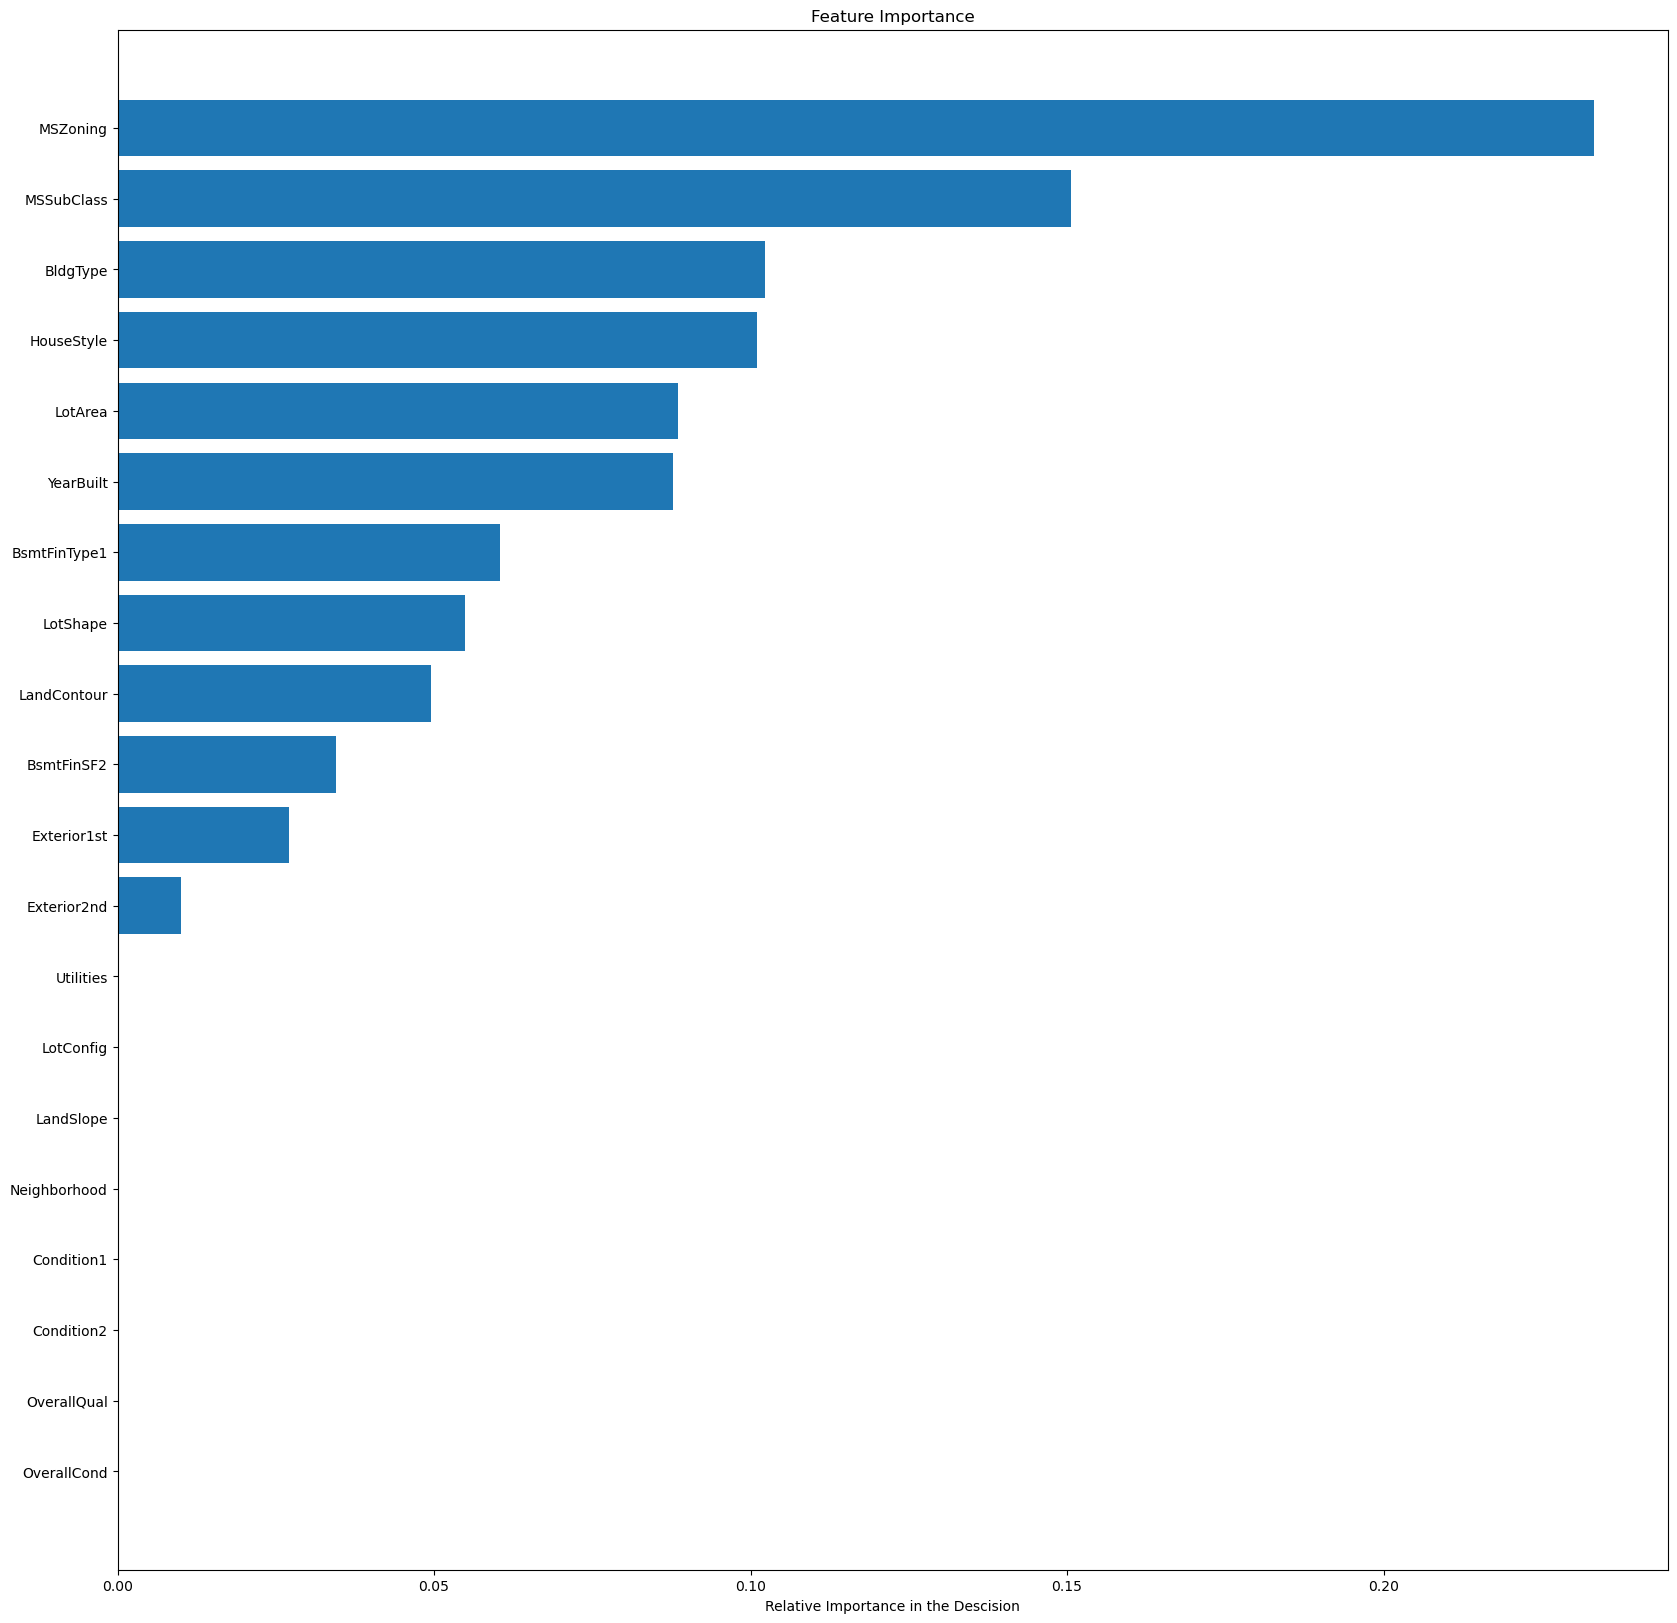

In [503]:
n_most_important = 20

dict_feature_importance = dict(zip(features, clf_corr.feature_importances_))
dict_feature_importance = {k: v for k, v in sorted(dict_feature_importance.items(), key=lambda item: item[1], reverse=True)}

fig, ax = plt.subplots()

y_pos = np.arange(len(features))

ax.barh(y_pos[:n_most_important], list(dict_feature_importance.values())[:n_most_important], align='center')
ax.set_yticks(y_pos[:n_most_important])
ax.set_yticklabels(list(dict_feature_importance.keys())[:n_most_important])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Relative Importance in the Descision')
ax.set_title('Feature Importance')

plt.show()

In [504]:
r2_score(y_valid.flatten(), clf_corr.predict(X_valid).flatten())

0.8831565001753726

The final performance of the model are: 
- **R2: 0.88**
- **RMSE: 26381**  

Reducing the field's subspace improved the performance of the model, and allowed it to outperform SF's model. Features selected by the model appear to be more relevant, however, some duplicate seems to have made their way in the final feature set selected by the model (Exterior 1st and Exterior 2nd). Furthermore, some may say some key amenities are not taken into account when predicting house prices. 
It is satisfying to see that items such as zoning (is the listing in an industrial, natural ... zone) are taken into account as well as the buidling class (house, appartment ...).  

## IV. XGBoost for Feature Selection 
To improve the performance of the model, we select features using the XGBoost regressor. This means having XGBoost doing the predictions and select features that provided the greater gain. 

In [545]:
df_xgboost = pd.read_csv('real_estate_price.csv')

def prepare_data(df):  
    id_columns = ["Id", "Street", "Alley"]
    unused_columns = [ "PoolQC", "Fence", "MiscFeature", "FireplaceQu", "LotFrontage"] #"GarageQual", "GarageCond", 
    df.drop(columns=id_columns + unused_columns, inplace=True)

    # take care of non-value 
    df = df.dropna(how='any')
    df = df.reset_index(drop=True)
    
    # ordinal encoding 
    for non_numerical_feature_name in dc.non_numerical_features(df):
        dc.feature_ordinalEncoding(df, non_numerical_feature_name, inplace=True)
    return df

df_xgboost = prepare_data(df_xgboost)

In [546]:
training_data, testing_data =  train_test_split(df_xgboost, test_size=0.2, random_state=4)

In [547]:
X_train, y_train = training_data.drop(columns="SalePrice"), training_data["SalePrice"]
X_test, y_test = testing_data.drop(columns="SalePrice"), testing_data["SalePrice"]

C:\Users\pmansat\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


R2: 0.79


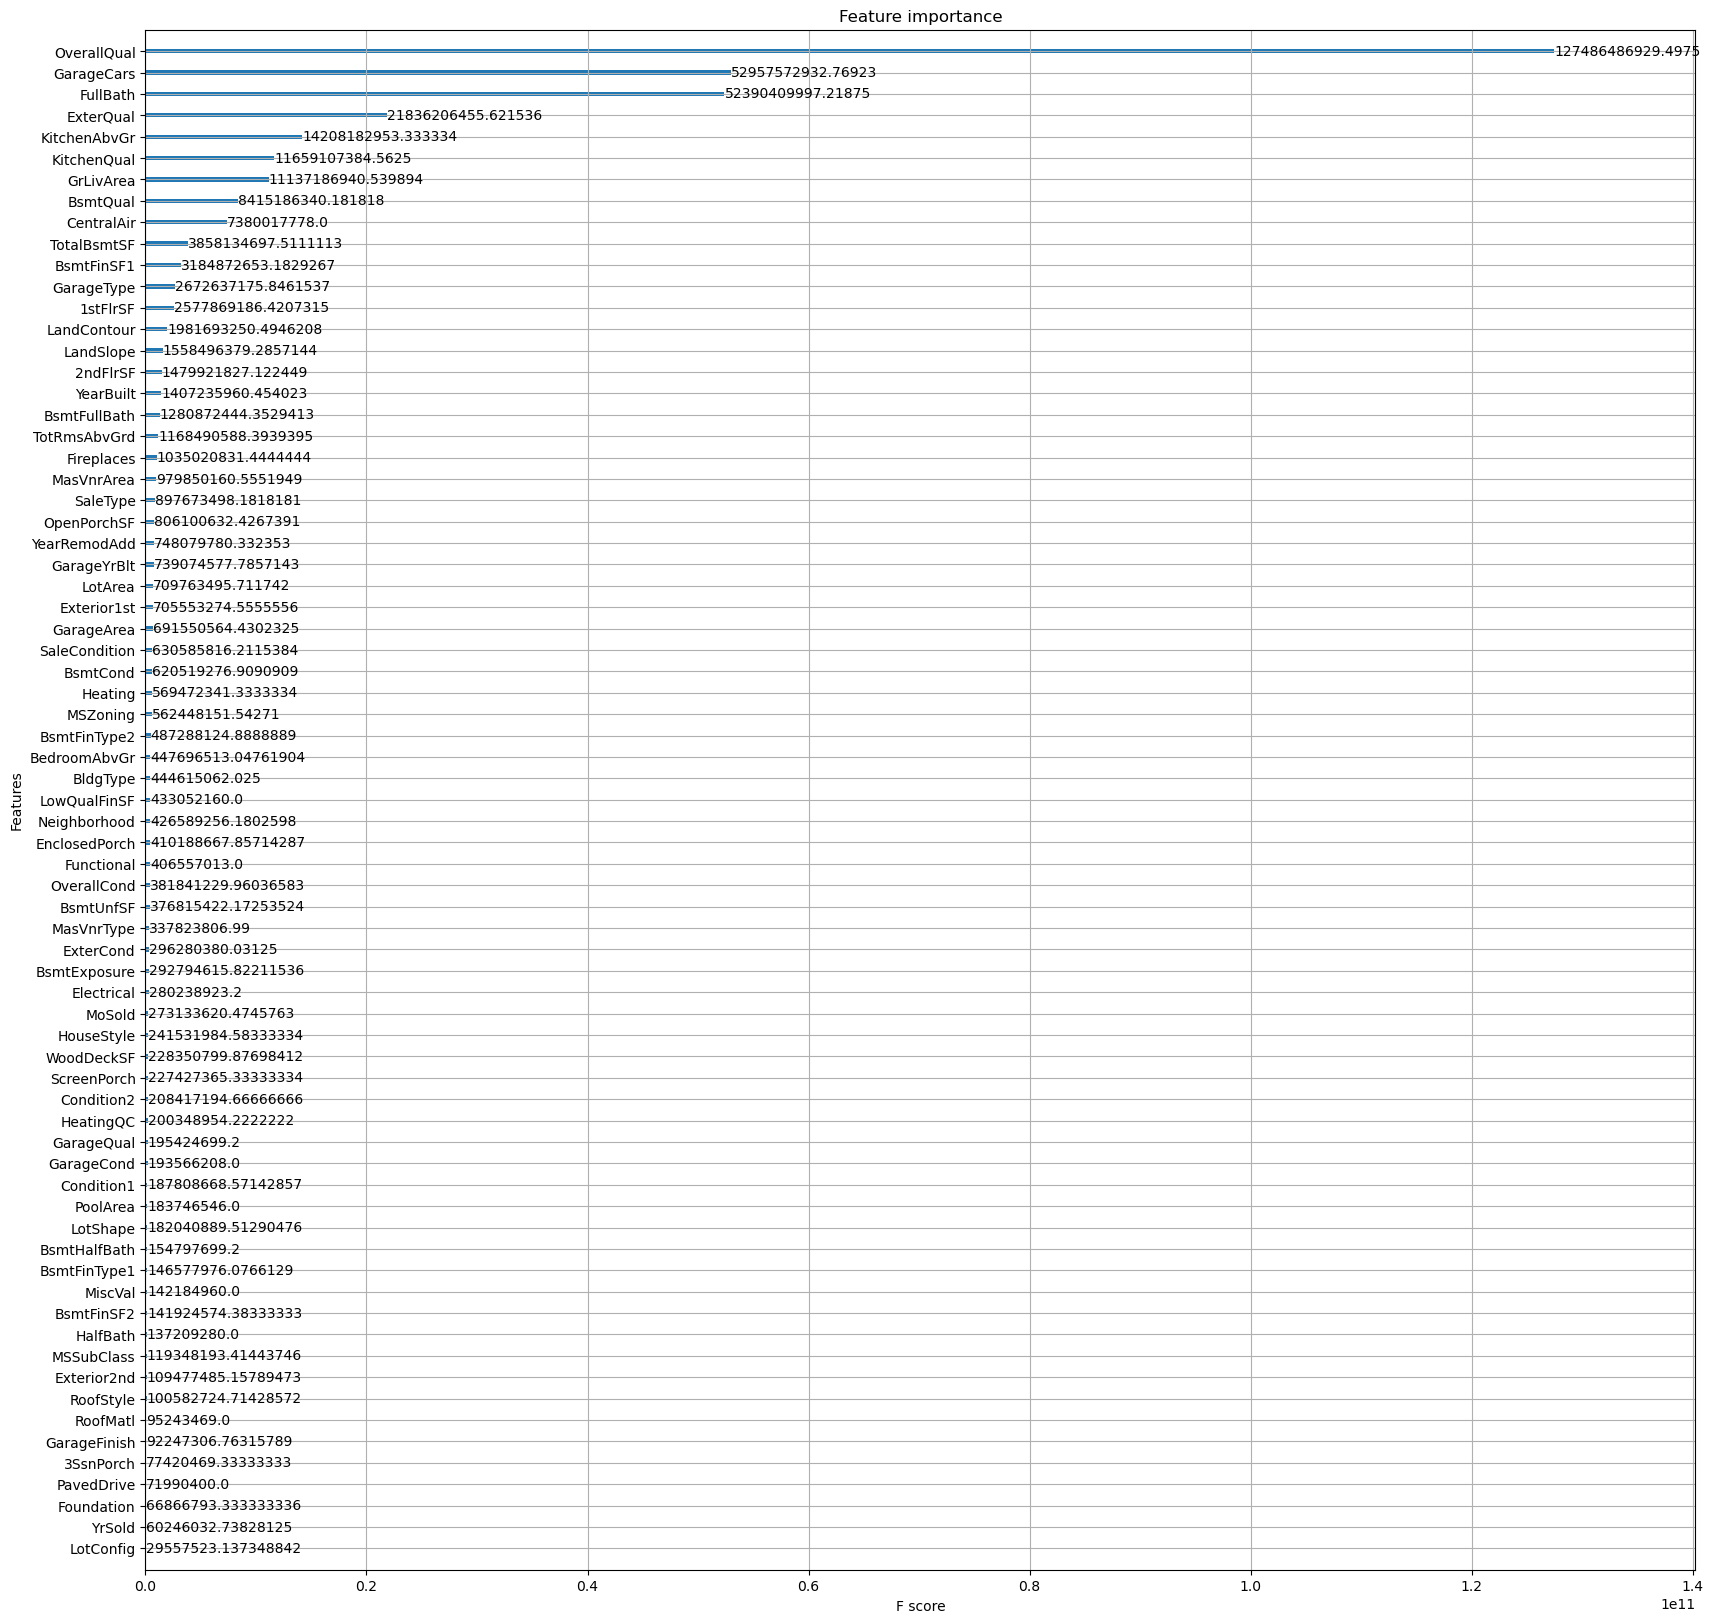

In [548]:
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.8, learning_rate = 0.3,
                max_depth = 10, alpha = 10, n_estimators = 20)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
print('R2: {:.2f}'.format(r2_score(y_pred, y_test)))
xgb.plot_importance(xg_reg, importance_type='gain')
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [549]:
importance_dict = xg_reg.get_booster().get_score(importance_type='gain')

C:\Users\pmansat\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


R2: 0.81


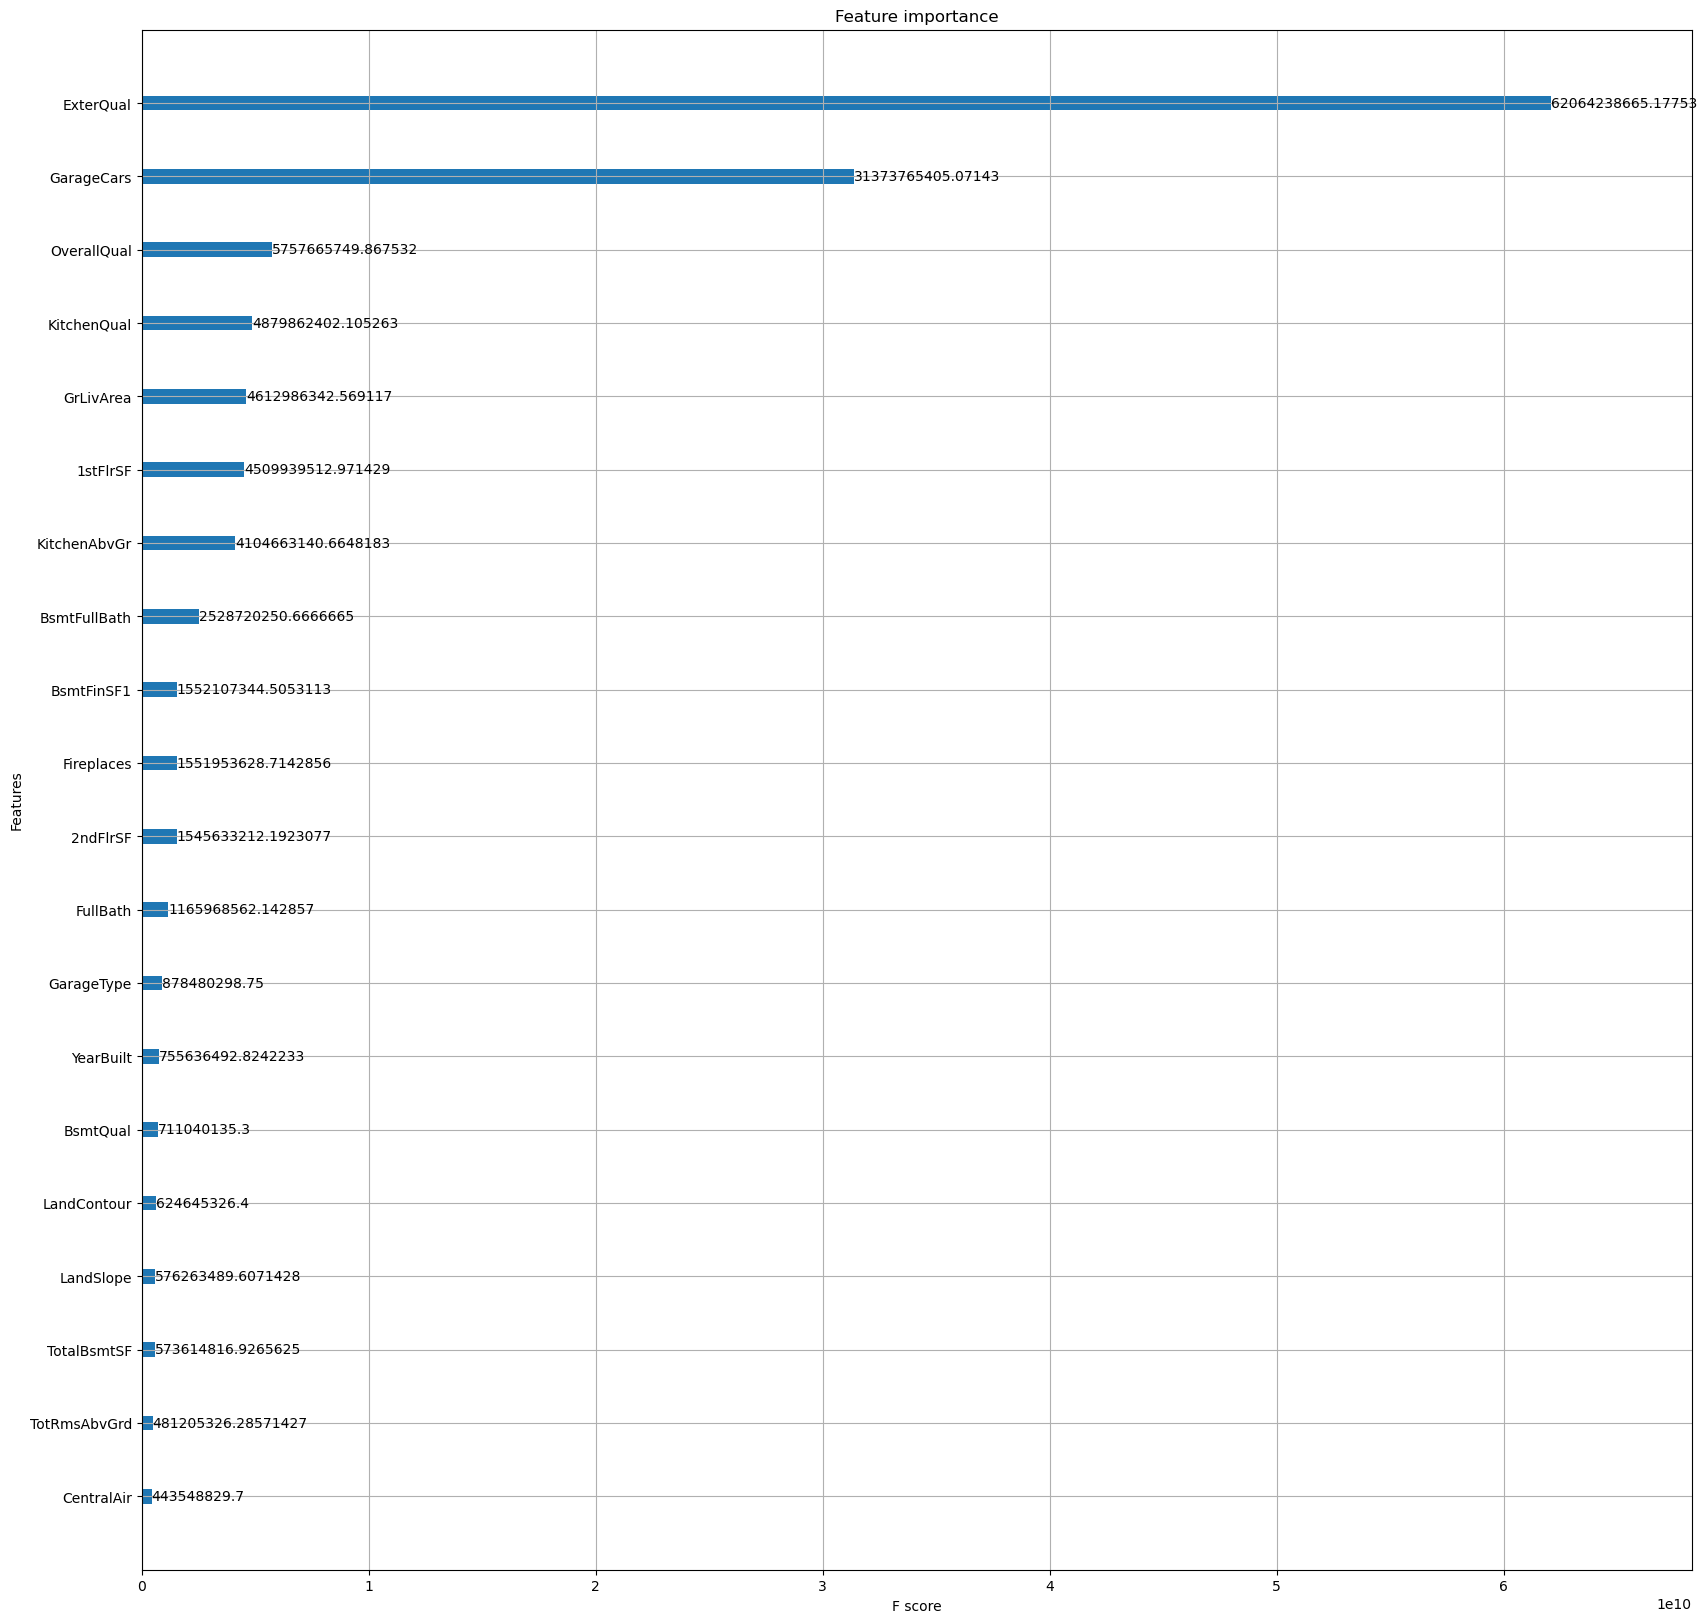

In [550]:
n_important = 20
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.8, learning_rate = 0.7,
                max_depth = 10, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train[[key for key in sorted(importance_dict, key=importance_dict.get, reverse=True)[:n_important]]], y_train)
y_pred = xg_reg.predict(X_test[[key for key in sorted(importance_dict, key=importance_dict.get, reverse=True)[:n_important]]])
print('R2: {:.2f}'.format(r2_score(y_pred, y_test)))
xgb.plot_importance(xg_reg, importance_type='gain')
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [551]:
clf_xgb, X_trainXGB, y_trainXGB, X_validXGB, y_validXGB, X_testXGB, y_testXGB = train_tabnet(data, sorted(importance_dict, key=importance_dict.get, reverse=True)[:n_important], 
                                                                            max_epochs=1000, lr=2e-1, lambda_sparse=1e-5, 
                                                                            n_steps=7)

Device used : cpu
epoch 0  | loss: 41521933750.85714| train_rmse: 203523.47733| valid_rmse: 211116.35683|  0:00:00s
epoch 1  | loss: 41512684305.32331| train_rmse: 202995.00956| valid_rmse: 210461.63713|  0:00:00s
epoch 2  | loss: 41497700028.63158| train_rmse: 203251.09511| valid_rmse: 210743.67833|  0:00:01s
epoch 3  | loss: 41479475692.75188| train_rmse: 201413.45425| valid_rmse: 209047.88853|  0:00:01s
epoch 4  | loss: 41453680208.8421| train_rmse: 201301.44839| valid_rmse: 208856.10234|  0:00:01s
epoch 5  | loss: 41411785781.89474| train_rmse: 200469.95639| valid_rmse: 207987.37494|  0:00:02s
epoch 6  | loss: 41348255220.45112| train_rmse: 200736.99876| valid_rmse: 208345.5552|  0:00:02s
epoch 7  | loss: 41257228426.58646| train_rmse: 199307.66712| valid_rmse: 206923.03738|  0:00:03s
epoch 8  | loss: 41135069815.33835| train_rmse: 197602.82312| valid_rmse: 205337.3493|  0:00:03s
epoch 9  | loss: 41010920517.29324| train_rmse: 196325.53522| valid_rmse: 204144.38551|  0:00:04s
epoch

epoch 85 | loss: 1059453213.83459| train_rmse: 70620.14865| valid_rmse: 84279.31784|  0:00:45s
epoch 86 | loss: 1098254360.06015| train_rmse: 65748.14637| valid_rmse: 81100.90131|  0:00:45s
epoch 87 | loss: 1136234626.40601| train_rmse: 62797.45493| valid_rmse: 78910.31714|  0:00:45s
epoch 88 | loss: 1193071905.20301| train_rmse: 60019.06759| valid_rmse: 79582.16843|  0:00:46s
epoch 89 | loss: 1217427881.38346| train_rmse: 48401.23329| valid_rmse: 68793.43625|  0:00:46s
epoch 90 | loss: 1296881292.51128| train_rmse: 50150.59928| valid_rmse: 69194.03697|  0:00:47s
epoch 91 | loss: 1140961786.22556| train_rmse: 48528.87051| valid_rmse: 70197.71308|  0:00:47s
epoch 92 | loss: 1240038169.50376| train_rmse: 44967.47597| valid_rmse: 67035.18942|  0:00:48s
epoch 93 | loss: 1104889861.77444| train_rmse: 42921.24228| valid_rmse: 63018.60959|  0:00:48s
epoch 94 | loss: 1163488290.88722| train_rmse: 42051.08175| valid_rmse: 60879.31132|  0:00:48s
epoch 95 | loss: 1172731856.84211| train_rmse: 408

epoch 173| loss: 840089129.86466| train_rmse: 29384.84302| valid_rmse: 51518.71124|  0:01:25s
epoch 174| loss: 912810562.88722| train_rmse: 29891.92714| valid_rmse: 51227.63158|  0:01:25s
epoch 175| loss: 834950491.42857| train_rmse: 29908.87526| valid_rmse: 51197.65998|  0:01:26s
epoch 176| loss: 825307363.12782| train_rmse: 28455.15714| valid_rmse: 51482.67717|  0:01:26s
epoch 177| loss: 875536763.66917| train_rmse: 28339.04177| valid_rmse: 54736.89838|  0:01:27s
epoch 178| loss: 854685006.91729| train_rmse: 30058.66243| valid_rmse: 57811.28652|  0:01:27s
epoch 179| loss: 848006096.84211| train_rmse: 31802.18877| valid_rmse: 60072.38696|  0:01:27s
epoch 180| loss: 809767745.44361| train_rmse: 31820.31833| valid_rmse: 66403.54647|  0:01:28s
epoch 181| loss: 855917286.97744| train_rmse: 29722.52026| valid_rmse: 64946.24128|  0:01:28s
epoch 182| loss: 809292317.83459| train_rmse: 29187.03899| valid_rmse: 64498.29901|  0:01:29s
epoch 183| loss: 867288687.15789| train_rmse: 29362.06183| v

epoch 261| loss: 647243275.06767| train_rmse: 27287.78777| valid_rmse: 58973.60252|  0:02:07s
epoch 262| loss: 788035148.99248| train_rmse: 26940.42385| valid_rmse: 59406.86814|  0:02:08s
epoch 263| loss: 631956122.94737| train_rmse: 26216.06062| valid_rmse: 57028.36416|  0:02:08s
epoch 264| loss: 615492989.59398| train_rmse: 26321.50893| valid_rmse: 55434.18192|  0:02:09s
epoch 265| loss: 678262310.49624| train_rmse: 26381.18709| valid_rmse: 55528.77341|  0:02:10s
epoch 266| loss: 653251882.34586| train_rmse: 26570.77299| valid_rmse: 59013.94901|  0:02:10s
epoch 267| loss: 655711136.2406| train_rmse: 26114.46927| valid_rmse: 61534.26936|  0:02:11s
epoch 268| loss: 620755270.25564| train_rmse: 24707.20784| valid_rmse: 60380.48704|  0:02:12s
epoch 269| loss: 617116868.33083| train_rmse: 25163.92995| valid_rmse: 55400.5636|  0:02:12s
epoch 270| loss: 782840262.25564| train_rmse: 27867.5056| valid_rmse: 55070.79134|  0:02:13s
epoch 271| loss: 634199716.09023| train_rmse: 30101.49749| vali

epoch 349| loss: 593701824.0| train_rmse: 25473.23524| valid_rmse: 50587.44158|  0:02:54s
epoch 350| loss: 591610494.07519| train_rmse: 24325.32377| valid_rmse: 49786.31577|  0:02:55s
epoch 351| loss: 564614505.86466| train_rmse: 25216.26206| valid_rmse: 49250.20458|  0:02:55s
epoch 352| loss: 556079878.01504| train_rmse: 26492.8033| valid_rmse: 50809.50396|  0:02:56s
epoch 353| loss: 697447603.48872| train_rmse: 26807.84779| valid_rmse: 51352.85417|  0:02:56s
epoch 354| loss: 677315657.14286| train_rmse: 26118.97318| valid_rmse: 51091.51305|  0:02:57s
epoch 355| loss: 608833091.36842| train_rmse: 24529.32119| valid_rmse: 51641.15374|  0:02:57s
epoch 356| loss: 646653736.42105| train_rmse: 26322.13941| valid_rmse: 53406.09282|  0:02:58s
epoch 357| loss: 606365126.73684| train_rmse: 27540.41076| valid_rmse: 52753.70479|  0:02:58s
epoch 358| loss: 639867864.54135| train_rmse: 26033.59152| valid_rmse: 56020.1884|  0:02:59s
epoch 359| loss: 630163015.21805| train_rmse: 24462.37809| valid_r

epoch 437| loss: 558814601.62406| train_rmse: 23941.8484| valid_rmse: 57256.49943|  0:03:36s
epoch 438| loss: 582511356.63158| train_rmse: 24301.27012| valid_rmse: 55609.30939|  0:03:37s
epoch 439| loss: 528808526.67669| train_rmse: 24225.15943| valid_rmse: 55253.09999|  0:03:37s
epoch 440| loss: 585251210.10526| train_rmse: 23780.35602| valid_rmse: 55882.86647|  0:03:37s
epoch 441| loss: 571857254.49624| train_rmse: 24117.1274| valid_rmse: 57417.36301|  0:03:38s
epoch 442| loss: 572895156.45113| train_rmse: 24291.15934| valid_rmse: 58830.13429|  0:03:38s
epoch 443| loss: 584539217.32331| train_rmse: 24576.40374| valid_rmse: 60609.66309|  0:03:39s
epoch 444| loss: 652879925.89474| train_rmse: 24697.9945| valid_rmse: 57544.69851|  0:03:39s
epoch 445| loss: 602615673.26316| train_rmse: 24370.25678| valid_rmse: 54963.16792|  0:03:39s
epoch 446| loss: 516201298.76692| train_rmse: 24527.82964| valid_rmse: 52191.29221|  0:03:40s
epoch 447| loss: 573644454.01504| train_rmse: 24552.28254| vali

epoch 525| loss: 537968200.66165| train_rmse: 24963.08557| valid_rmse: 55521.22275|  0:04:18s
epoch 526| loss: 528302058.34586| train_rmse: 23855.62466| valid_rmse: 54762.57432|  0:04:18s
epoch 527| loss: 522743632.3609| train_rmse: 21959.69264| valid_rmse: 51859.36156|  0:04:19s
epoch 528| loss: 480723162.94737| train_rmse: 21190.68315| valid_rmse: 49265.17292|  0:04:19s
epoch 529| loss: 534717996.99248| train_rmse: 21601.40413| valid_rmse: 49554.43746|  0:04:20s
epoch 530| loss: 507364250.94737| train_rmse: 22168.98047| valid_rmse: 53261.56891|  0:04:21s
epoch 531| loss: 562082355.48872| train_rmse: 22010.53185| valid_rmse: 57506.98041|  0:04:21s
epoch 532| loss: 488247859.00752| train_rmse: 21180.93271| valid_rmse: 60570.30775|  0:04:22s
epoch 533| loss: 520699422.79699| train_rmse: 20996.96948| valid_rmse: 61304.21548|  0:04:22s
epoch 534| loss: 709379102.79699| train_rmse: 21670.46424| valid_rmse: 59954.08216|  0:04:23s
epoch 535| loss: 460869971.24812| train_rmse: 21993.26855| va

epoch 613| loss: 454358926.19549| train_rmse: 23462.36903| valid_rmse: 51408.33125|  0:05:03s
epoch 614| loss: 453912863.7594| train_rmse: 23605.91647| valid_rmse: 49149.61669|  0:05:03s
epoch 615| loss: 445143103.5188| train_rmse: 22901.42399| valid_rmse: 46172.13731|  0:05:04s
epoch 616| loss: 512227447.09774| train_rmse: 21922.85642| valid_rmse: 44721.66443|  0:05:04s
epoch 617| loss: 450337422.43609| train_rmse: 22682.39711| valid_rmse: 44803.62831|  0:05:05s
epoch 618| loss: 436426208.2406| train_rmse: 23055.01934| valid_rmse: 44656.58376|  0:05:05s
epoch 619| loss: 424377824.7218| train_rmse: 23238.58705| valid_rmse: 45981.39674|  0:05:05s
epoch 620| loss: 446986961.56391| train_rmse: 22821.55797| valid_rmse: 46632.32539|  0:05:06s
epoch 621| loss: 459246082.88722| train_rmse: 21331.03| valid_rmse: 47062.30227|  0:05:06s
epoch 622| loss: 418236700.87218| train_rmse: 20941.96605| valid_rmse: 47653.14771|  0:05:07s
epoch 623| loss: 439811251.24812| train_rmse: 21871.89026| valid_rm

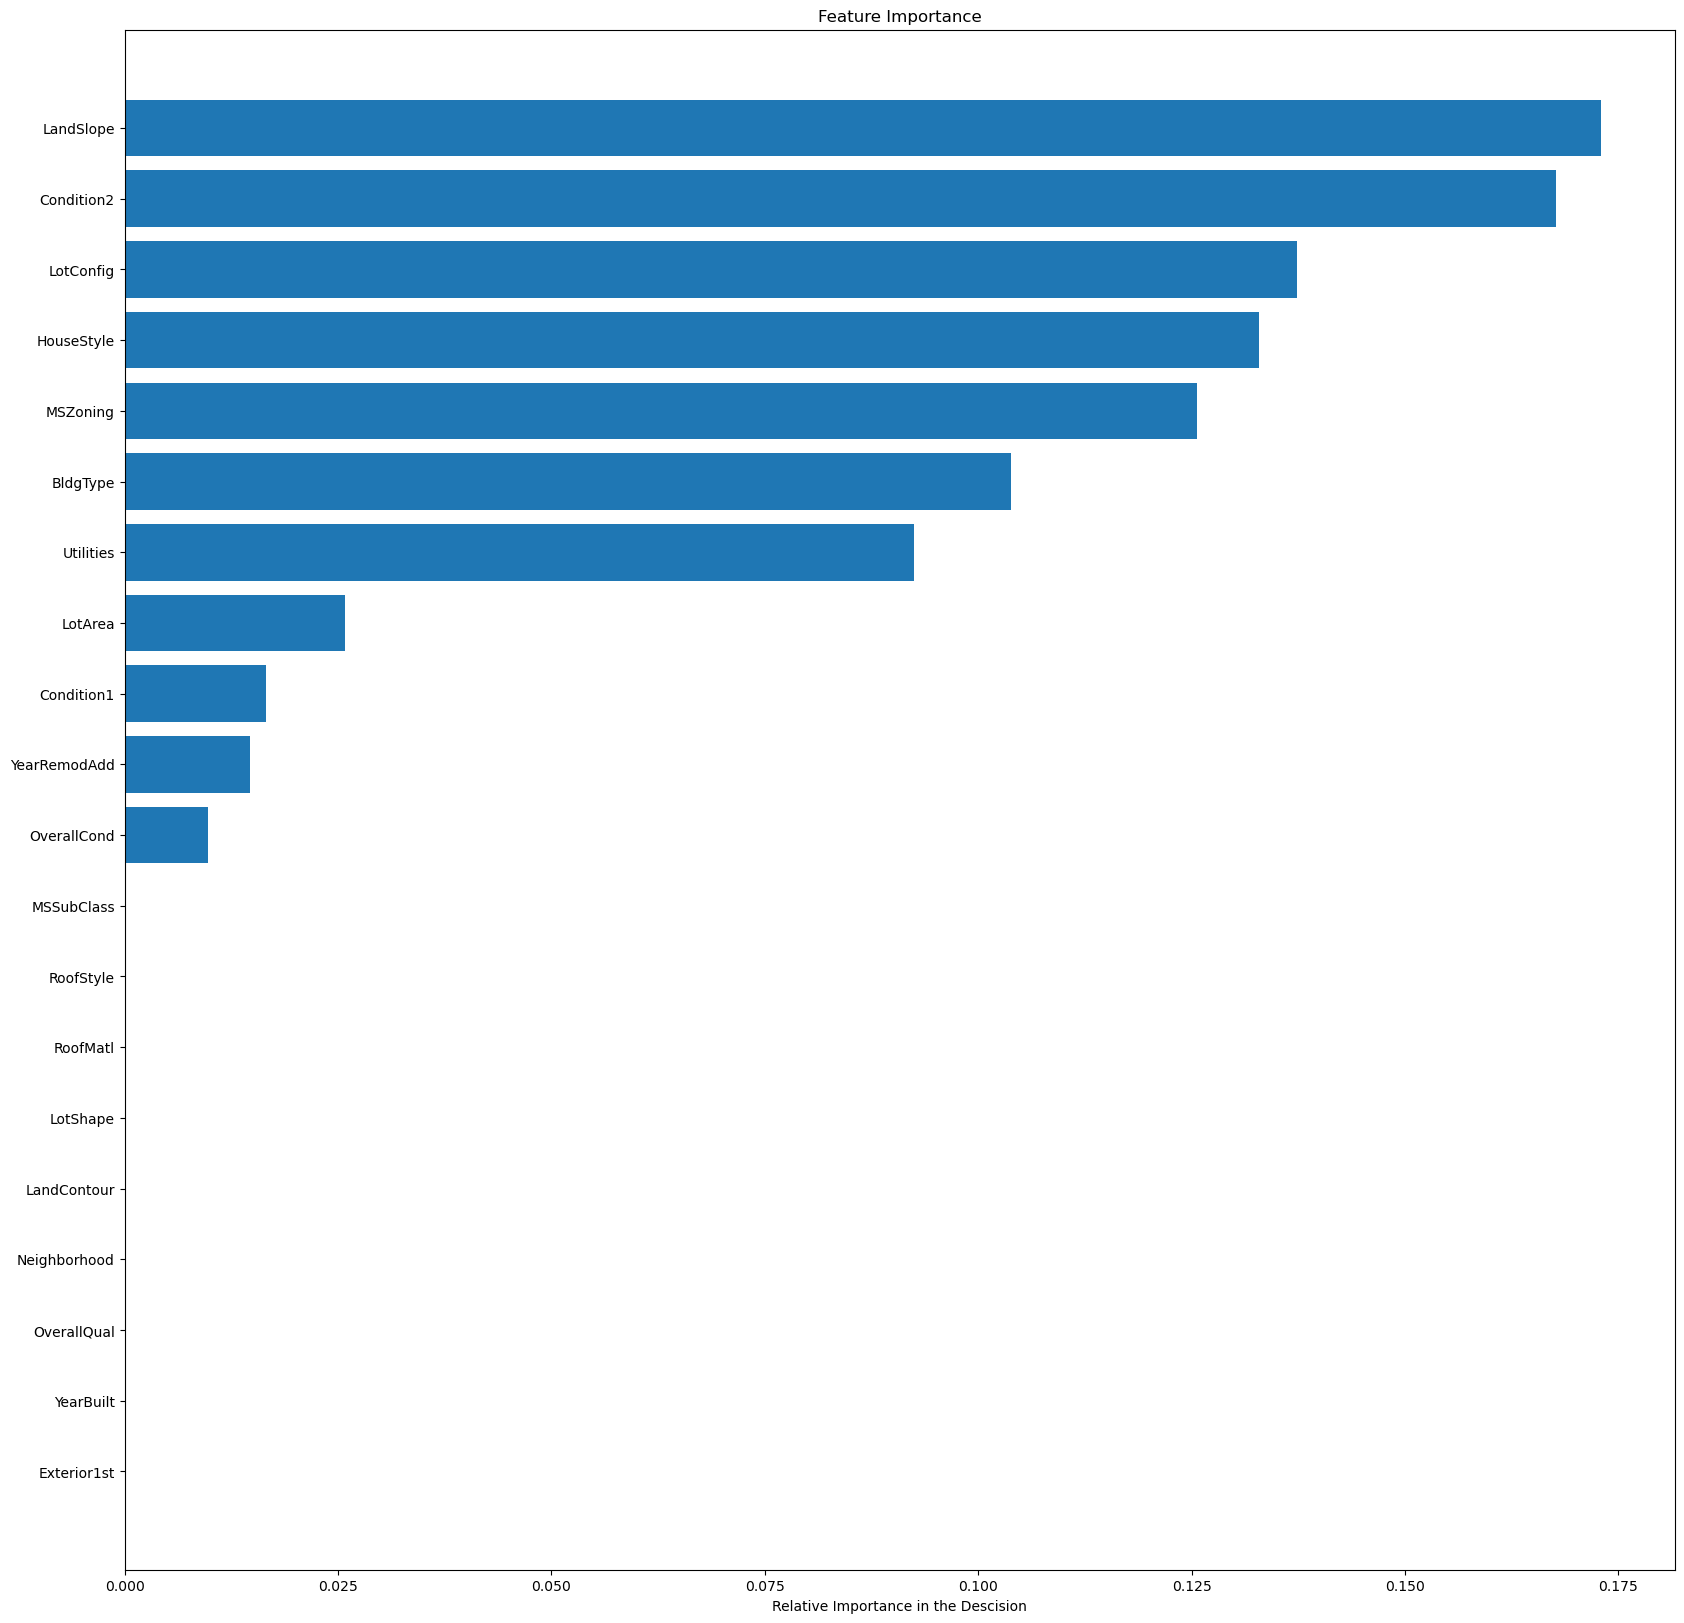

In [552]:
n_most_important = 20

dict_feature_importance = dict(zip(features, clf_xgb.feature_importances_))
dict_feature_importance = {k: v for k, v in sorted(dict_feature_importance.items(), key=lambda item: item[1], reverse=True)}

fig, ax = plt.subplots()

y_pos = np.arange(len(features))

ax.barh(y_pos[:n_most_important], list(dict_feature_importance.values())[:n_most_important], align='center')
ax.set_yticks(y_pos[:n_most_important])
ax.set_yticklabels(list(dict_feature_importance.keys())[:n_most_important])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Relative Importance in the Descision')
ax.set_title('Feature Importance')

plt.show()

In [581]:
print("R2 score: {:.2f}".format(r2_score(y_validXGB.flatten(), clf_xgb.predict(X_validXGB).flatten())))

R2 score: 0.80


The final performance of the model are: 
- **R2: 0.80**
- **RMSE: 4052**  

Result is not great, the main reason might be because important features such as neigh. were discared. However, some features such as LotConfig (house's type), condition (= proximity to main road or railway) appear which can play a significant role in selecting features. 

## V. WiSe Feature Selection
To select the most relevant features, we use WiSe (Wide Spectrum) feature selection process. The latter process is defined in a sperated file, the features returned by the algorithm are the one presented bellow. 

In [538]:
# features selected using WiSe methodology 
selected = ['SaleCondition', 'BsmtUnfSF', 'YearRemodAdd', 'OverallQual', 'RoofMatl',
       'ExterCond', 'GarageArea', 'MoSold', 'TotalBsmtSF', '2ndFlrSF',
       'Exterior1st', 'HouseStyle', 'LandSlope', 'BsmtFinSF1', '3SsnPorch',
       'Condition1', 'YearBuilt', 'BsmtFullBath', 'MasVnrArea', 'Electrical',
       'Functional', 'RoofStyle', 'HalfBath', 'GrLivArea', 'CentralAir',
       'Fireplaces', 'OpenPorchSF', 'ScreenPorch', 'FullBath', 'GarageCars',
       'WoodDeckSF', 'GarageCond', 'BsmtFinType2', 'PoolArea', 'BedroomAbvGr',
       'Foundation', 'Neighborhood', '1stFlrSF', 'TotRmsAbvGrd', 'GarageQual',
       'LotArea', 'GarageYrBlt', 'Exterior2nd', 'BsmtCond', 'PavedDrive']

In [539]:
clf_select, X_trainSELECT, y_trainSELECT, X_validSELECT, y_validSELECT, X_testSELECT, y_testSELECT = train_tabnet(data, selected, 
                                                                            max_epochs=1000, lr=2e-1, lambda_sparse=1e-5, 
                                                                            n_steps=7)

Device used : cpu
epoch 0  | loss: 40762325353.41176| train_rmse: 201595.68395| valid_rmse: 205445.28213|  0:00:00s
epoch 1  | loss: 40750187821.17647| train_rmse: 201389.21792| valid_rmse: 205248.15506|  0:00:00s
epoch 2  | loss: 40728520583.52941| train_rmse: 200552.53938| valid_rmse: 204461.22804|  0:00:01s
epoch 3  | loss: 40699399951.05882| train_rmse: 200300.33346| valid_rmse: 204154.9736|  0:00:01s
epoch 4  | loss: 40664179049.41176| train_rmse: 199374.17693| valid_rmse: 203323.05884|  0:00:02s
epoch 5  | loss: 40610311228.23529| train_rmse: 199138.43294| valid_rmse: 202961.24475|  0:00:02s
epoch 6  | loss: 40533314258.82353| train_rmse: 198776.57607| valid_rmse: 202553.38045|  0:00:03s
epoch 7  | loss: 40426749229.17647| train_rmse: 198501.50436| valid_rmse: 202322.19272|  0:00:04s
epoch 8  | loss: 40302564050.82353| train_rmse: 198775.31283| valid_rmse: 202606.59793|  0:00:05s
epoch 9  | loss: 40147746334.11764| train_rmse: 198752.32044| valid_rmse: 202437.71627|  0:00:05s
epo

epoch 85 | loss: 1140361637.64706| train_rmse: 62267.51542| valid_rmse: 53151.25414|  0:00:46s
epoch 86 | loss: 1175561720.47059| train_rmse: 77841.72711| valid_rmse: 63725.80432|  0:00:46s
epoch 87 | loss: 1121323843.76471| train_rmse: 78273.07869| valid_rmse: 66245.43018|  0:00:47s
epoch 88 | loss: 1044957244.23529| train_rmse: 81280.66779| valid_rmse: 75054.2252|  0:00:47s
epoch 89 | loss: 1105093104.94118| train_rmse: 93449.76798| valid_rmse: 87778.49384|  0:00:48s
epoch 90 | loss: 1055695491.76471| train_rmse: 97733.77548| valid_rmse: 93334.69485|  0:00:49s
epoch 91 | loss: 1048847262.11765| train_rmse: 89609.71481| valid_rmse: 86179.40045|  0:00:49s
epoch 92 | loss: 964052973.17647| train_rmse: 67439.4551| valid_rmse: 63866.77477|  0:00:50s
epoch 93 | loss: 950601682.82353| train_rmse: 49273.18732| valid_rmse: 46330.91946|  0:00:50s
epoch 94 | loss: 1101463235.76471| train_rmse: 43346.85522| valid_rmse: 41646.90161|  0:00:51s
epoch 95 | loss: 1209506040.47059| train_rmse: 43011.3

epoch 173| loss: 796592414.11765| train_rmse: 31637.22808| valid_rmse: 34794.90779|  0:01:36s
epoch 174| loss: 778119096.47059| train_rmse: 28424.40009| valid_rmse: 30922.21374|  0:01:37s
epoch 175| loss: 790165955.76471| train_rmse: 28601.41486| valid_rmse: 30843.82059|  0:01:37s
epoch 176| loss: 732832538.35294| train_rmse: 34226.32866| valid_rmse: 35014.53932|  0:01:38s
epoch 177| loss: 787097825.88235| train_rmse: 35780.34969| valid_rmse: 35098.14214|  0:01:38s
epoch 178| loss: 823873829.64706| train_rmse: 31439.90018| valid_rmse: 32285.97861|  0:01:39s
epoch 179| loss: 779127988.70588| train_rmse: 30124.68471| valid_rmse: 31835.54673|  0:01:40s
epoch 180| loss: 797327856.94118| train_rmse: 27977.79472| valid_rmse: 29697.94776|  0:01:40s
epoch 181| loss: 770681750.58824| train_rmse: 28984.6483| valid_rmse: 30387.54959|  0:01:41s
epoch 182| loss: 789961588.70588| train_rmse: 30284.85764| valid_rmse: 31786.91776|  0:01:41s
epoch 183| loss: 796891610.35294| train_rmse: 30736.17163| va

epoch 261| loss: 743710900.70588| train_rmse: 29107.31995| valid_rmse: 32257.45224|  0:02:27s
epoch 262| loss: 764618800.94118| train_rmse: 31350.95427| valid_rmse: 33984.79892|  0:02:27s
epoch 263| loss: 829447589.64706| train_rmse: 33423.98802| valid_rmse: 35762.3144|  0:02:28s
epoch 264| loss: 741411606.58824| train_rmse: 33589.17635| valid_rmse: 34169.54403|  0:02:28s
epoch 265| loss: 705191905.88235| train_rmse: 31735.35009| valid_rmse: 32556.41448|  0:02:29s
epoch 266| loss: 769506240.0| train_rmse: 30129.54508| valid_rmse: 31226.76298|  0:02:29s
epoch 267| loss: 750950746.35294| train_rmse: 29921.66061| valid_rmse: 31280.40254|  0:02:30s
epoch 268| loss: 707795941.64706| train_rmse: 29790.92162| valid_rmse: 31441.8791|  0:02:30s
epoch 269| loss: 731768075.29412| train_rmse: 29247.63551| valid_rmse: 30809.50936|  0:02:31s
epoch 270| loss: 750945999.05882| train_rmse: 28715.07139| valid_rmse: 30761.6903|  0:02:32s
epoch 271| loss: 693806893.17647| train_rmse: 28359.04871| valid_rm

epoch 349| loss: 743372344.47059| train_rmse: 26397.7089| valid_rmse: 33432.41143|  0:03:15s
epoch 350| loss: 766856862.11765| train_rmse: 26242.5331| valid_rmse: 34299.35064|  0:03:16s
epoch 351| loss: 675959680.0| train_rmse: 26073.43191| valid_rmse: 34286.64086|  0:03:16s
epoch 352| loss: 662724557.17647| train_rmse: 26704.40539| valid_rmse: 31879.01306|  0:03:17s
epoch 353| loss: 674656007.52941| train_rmse: 28875.75593| valid_rmse: 33261.51134|  0:03:18s
epoch 354| loss: 742297633.88235| train_rmse: 28811.56444| valid_rmse: 33479.82298|  0:03:18s
epoch 355| loss: 718597579.29412| train_rmse: 27985.75088| valid_rmse: 32712.07135|  0:03:19s
epoch 356| loss: 712959721.41176| train_rmse: 27385.62| valid_rmse: 32791.36269|  0:03:20s
epoch 357| loss: 667928786.82353| train_rmse: 27750.14689| valid_rmse: 33575.28201|  0:03:20s
epoch 358| loss: 675353583.05882| train_rmse: 28555.82214| valid_rmse: 34451.96573|  0:03:21s
epoch 359| loss: 690532288.0| train_rmse: 30368.12797| valid_rmse: 35

epoch 437| loss: 663508329.41176| train_rmse: 26040.37803| valid_rmse: 31089.64506|  0:04:07s
epoch 438| loss: 692562002.82353| train_rmse: 25383.9911| valid_rmse: 30970.55852|  0:04:08s
epoch 439| loss: 662658597.64706| train_rmse: 25304.04938| valid_rmse: 30283.94766|  0:04:08s
epoch 440| loss: 646188984.47059| train_rmse: 25749.3102| valid_rmse: 29869.35081|  0:04:09s
epoch 441| loss: 666121349.64706| train_rmse: 25513.36764| valid_rmse: 29612.96882|  0:04:09s
epoch 442| loss: 641422900.70588| train_rmse: 25314.39338| valid_rmse: 28998.71301|  0:04:10s
epoch 443| loss: 662288233.41176| train_rmse: 25187.18856| valid_rmse: 29049.02588|  0:04:10s
epoch 444| loss: 611507538.82353| train_rmse: 25500.53352| valid_rmse: 29652.60431|  0:04:11s
epoch 445| loss: 616518256.94118| train_rmse: 26501.58826| valid_rmse: 30400.62482|  0:04:12s
epoch 446| loss: 716185287.52941| train_rmse: 26432.50665| valid_rmse: 31055.91607|  0:04:12s
epoch 447| loss: 639367593.41176| train_rmse: 25468.61932| val

epoch 525| loss: 694097099.29412| train_rmse: 29666.75266| valid_rmse: 33398.88728|  0:04:58s
epoch 526| loss: 734518889.41176| train_rmse: 30816.97367| valid_rmse: 34128.22343|  0:04:59s
epoch 527| loss: 709259911.52941| train_rmse: 31053.59348| valid_rmse: 34098.0678|  0:05:00s
epoch 528| loss: 614670697.41176| train_rmse: 32804.18237| valid_rmse: 34875.49728|  0:05:01s
epoch 529| loss: 699649856.0| train_rmse: 33107.23992| valid_rmse: 36925.77451|  0:05:01s
epoch 530| loss: 658859787.29412| train_rmse: 31442.26292| valid_rmse: 36877.60787|  0:05:02s
epoch 531| loss: 697427175.52941| train_rmse: 30033.91152| valid_rmse: 35255.84345|  0:05:03s
epoch 532| loss: 633543917.17647| train_rmse: 29444.65579| valid_rmse: 36176.89664|  0:05:03s
epoch 533| loss: 665516024.47059| train_rmse: 30096.66847| valid_rmse: 35492.58377|  0:05:04s
epoch 534| loss: 634087582.11765| train_rmse: 31017.71032| valid_rmse: 36321.29014|  0:05:04s
epoch 535| loss: 716290974.11765| train_rmse: 31250.97943| valid_

epoch 613| loss: 626804736.0| train_rmse: 27299.34478| valid_rmse: 30540.08851|  0:05:47s
epoch 614| loss: 646744681.41176| train_rmse: 24586.6576| valid_rmse: 29000.90947|  0:05:47s
epoch 615| loss: 645916058.35294| train_rmse: 24275.30349| valid_rmse: 29557.68154|  0:05:48s
epoch 616| loss: 665948928.0| train_rmse: 24666.78298| valid_rmse: 29791.419|  0:05:48s
epoch 617| loss: 621278893.17647| train_rmse: 25049.93653| valid_rmse: 30014.50714|  0:05:49s
epoch 618| loss: 695836687.05882| train_rmse: 24872.12274| valid_rmse: 30118.9494|  0:05:50s
epoch 619| loss: 616225253.64706| train_rmse: 24776.21532| valid_rmse: 29485.95299|  0:05:50s
epoch 620| loss: 631468758.58824| train_rmse: 24505.87614| valid_rmse: 29011.34291|  0:05:51s
epoch 621| loss: 574566128.94118| train_rmse: 23476.1901| valid_rmse: 27671.39366|  0:05:51s
epoch 622| loss: 551739704.47059| train_rmse: 23344.25097| valid_rmse: 27156.56541|  0:05:52s
epoch 623| loss: 649370223.05882| train_rmse: 23494.75572| valid_rmse: 27

epoch 701| loss: 647746243.76471| train_rmse: 24572.23534| valid_rmse: 29217.86787|  0:06:35s
epoch 702| loss: 625847378.82353| train_rmse: 25340.53284| valid_rmse: 30229.40376|  0:06:36s
epoch 703| loss: 636017615.05882| train_rmse: 25313.43914| valid_rmse: 30043.94801|  0:06:36s
epoch 704| loss: 597706272.0| train_rmse: 25959.79005| valid_rmse: 30247.36092|  0:06:37s
epoch 705| loss: 588828116.70588| train_rmse: 27449.49126| valid_rmse: 32643.59433|  0:06:37s
epoch 706| loss: 613220813.17647| train_rmse: 27362.92635| valid_rmse: 32360.3102|  0:06:38s
epoch 707| loss: 600607399.52941| train_rmse: 26811.55356| valid_rmse: 31607.14029|  0:06:39s
epoch 708| loss: 588473605.64706| train_rmse: 26587.05358| valid_rmse: 30903.87373|  0:06:39s
epoch 709| loss: 614727653.64706| train_rmse: 26315.14483| valid_rmse: 30567.44571|  0:06:40s
epoch 710| loss: 572557925.64706| train_rmse: 26311.58133| valid_rmse: 30076.41172|  0:06:40s
epoch 711| loss: 565282002.82353| train_rmse: 26688.49299| valid_

epoch 789| loss: 464001880.47059| train_rmse: 23658.73172| valid_rmse: 28778.11681|  0:07:26s
epoch 790| loss: 469281317.64706| train_rmse: 25548.50583| valid_rmse: 29742.42908|  0:07:26s
epoch 791| loss: 476379286.58824| train_rmse: 30096.57353| valid_rmse: 33502.75613|  0:07:27s
epoch 792| loss: 549288941.17647| train_rmse: 31446.91778| valid_rmse: 34912.43965|  0:07:27s
epoch 793| loss: 481872553.41176| train_rmse: 28992.66976| valid_rmse: 32929.96319|  0:07:28s
epoch 794| loss: 451230825.41176| train_rmse: 24725.68329| valid_rmse: 29629.53833|  0:07:28s
epoch 795| loss: 459975567.05882| train_rmse: 24470.40575| valid_rmse: 29304.09616|  0:07:29s
epoch 796| loss: 445646339.76471| train_rmse: 30871.83876| valid_rmse: 34539.94784|  0:07:30s
epoch 797| loss: 484105370.35294| train_rmse: 33796.56249| valid_rmse: 36814.06995|  0:07:30s
epoch 798| loss: 503458160.94118| train_rmse: 27290.3693| valid_rmse: 31151.69405|  0:07:31s
epoch 799| loss: 434402021.64706| train_rmse: 22452.43404| va

epoch 877| loss: 383894494.11765| train_rmse: 19026.93119| valid_rmse: 26653.80395|  0:08:14s
epoch 878| loss: 317276184.47059| train_rmse: 21924.13646| valid_rmse: 28407.07346|  0:08:15s
epoch 879| loss: 367122127.05882| train_rmse: 17941.98602| valid_rmse: 25827.94989|  0:08:15s
epoch 880| loss: 311490511.05882| train_rmse: 18492.0704| valid_rmse: 26611.29818|  0:08:16s
epoch 881| loss: 316726085.64706| train_rmse: 24064.13923| valid_rmse: 30128.57351|  0:08:16s
epoch 882| loss: 341886727.52941| train_rmse: 28108.87795| valid_rmse: 32826.41604|  0:08:17s
epoch 883| loss: 328337118.11765| train_rmse: 22961.01412| valid_rmse: 28921.18144|  0:08:18s
epoch 884| loss: 340090396.23529| train_rmse: 17150.27347| valid_rmse: 25221.04964|  0:08:18s
epoch 885| loss: 405083968.0| train_rmse: 21803.96001| valid_rmse: 28417.80358|  0:08:19s
epoch 886| loss: 382469993.41176| train_rmse: 24572.69349| valid_rmse: 31605.07846|  0:08:19s
epoch 887| loss: 373435704.47059| train_rmse: 25191.28123| valid_

epoch 965| loss: 323278113.88235| train_rmse: 20684.03852| valid_rmse: 28552.51565|  0:09:05s
epoch 966| loss: 244592707.76471| train_rmse: 24606.73156| valid_rmse: 31591.04461|  0:09:05s
epoch 967| loss: 299848790.58824| train_rmse: 23014.20714| valid_rmse: 30043.41648|  0:09:06s
epoch 968| loss: 249952944.94118| train_rmse: 22236.91256| valid_rmse: 29230.3289|  0:09:06s
epoch 969| loss: 275043829.64706| train_rmse: 15474.68696| valid_rmse: 25545.03826|  0:09:07s
epoch 970| loss: 245553155.76471| train_rmse: 15495.1892| valid_rmse: 26276.54121|  0:09:07s
epoch 971| loss: 266129679.05882| train_rmse: 15663.00609| valid_rmse: 26450.44861|  0:09:08s
epoch 972| loss: 275749936.94118| train_rmse: 20100.21541| valid_rmse: 29271.56713|  0:09:09s
epoch 973| loss: 246509200.94118| train_rmse: 25021.30987| valid_rmse: 32283.54546|  0:09:09s
epoch 974| loss: 334397778.82353| train_rmse: 15344.47679| valid_rmse: 26015.40989|  0:09:10s
epoch 975| loss: 255412294.58824| train_rmse: 15232.32077| val

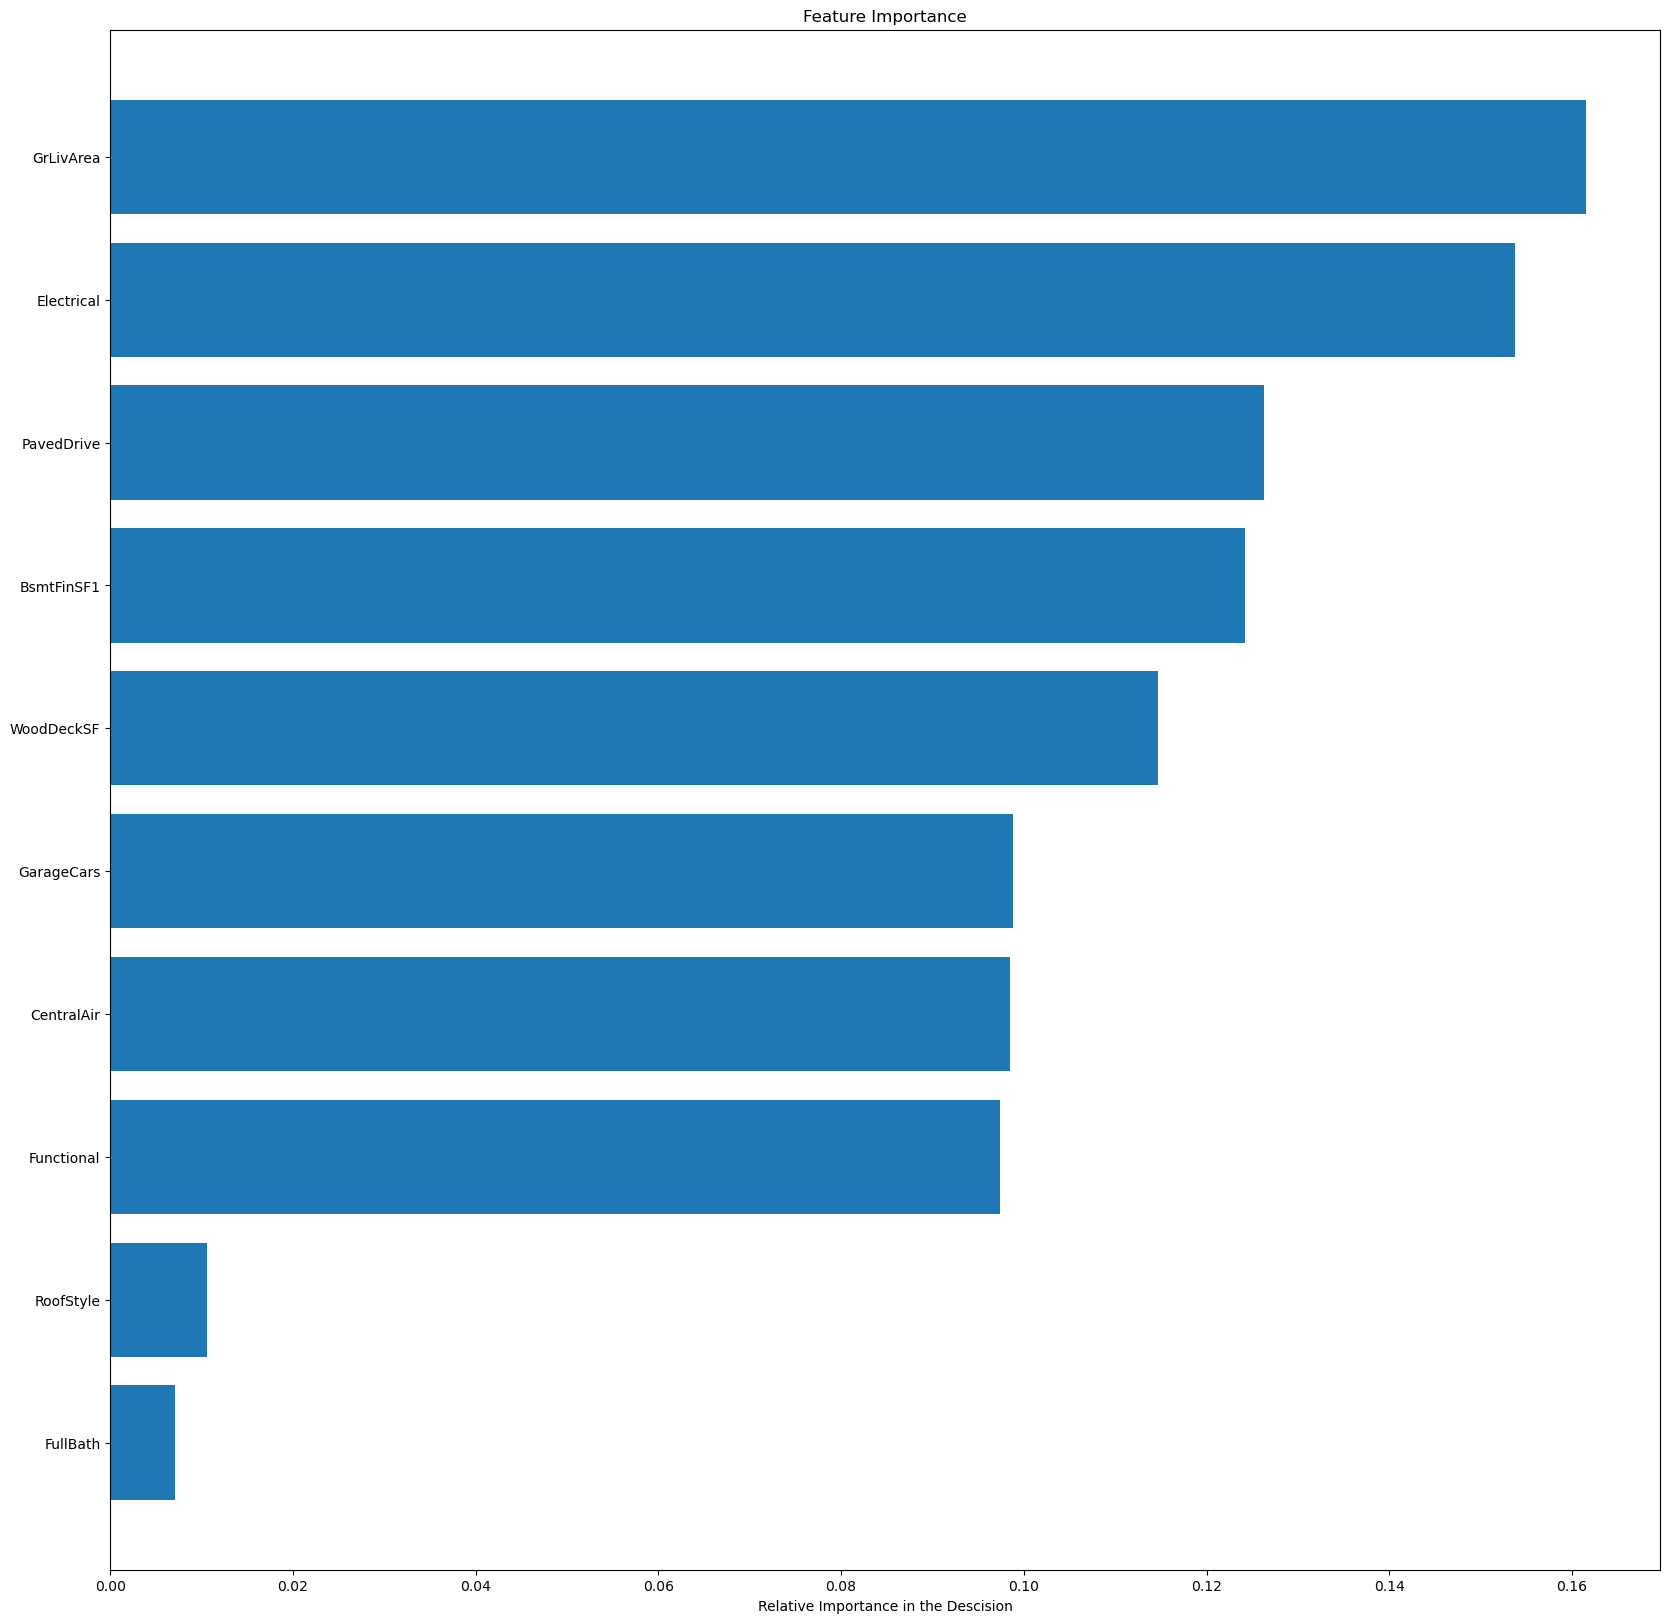

In [536]:
n_most_important = 10

dict_feature_importance = dict(zip(selected, clf_select.feature_importances_))
dict_feature_importance = {k: v for k, v in sorted(dict_feature_importance.items(), key=lambda item: item[1], reverse=True)}

fig, ax = plt.subplots()

y_pos = np.arange(len(selected))

ax.barh(y_pos[:n_most_important], list(dict_feature_importance.values())[:n_most_important], align='center')
ax.set_yticks(y_pos[:n_most_important])
ax.set_yticklabels(list(dict_feature_importance.keys())[:n_most_important])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Relative Importance in the Descision')
ax.set_title('Feature Importance')

plt.show()

In [570]:
print("R2 score: {:.2f}".format(r2_score(y_validSELECT.flatten(), clf_select.predict(X_validSELECT).flatten())))

R2 score: 0.91


The final performance of the model are: 
- **R2: 0.91**
- **RMSE: 24691**   

So without any feature selection method, the model is able to already reach SF performances. However, when looking at the features selected by SF, one may think they do not represent well how a price should be defined. According to the model, the categorical features BsmtFullBath is the most relevant features to predict the sale's price, which is strange to say the least...   
Some feature selection must be applied to encourage the model to find an optimal solution on a smaller field's space. 

## VI. Instinct Feature Selection

In [567]:
selected_instinct = ["MSSubClass", "MSZoning", "LotArea", "LotConfig", "Neighborhood", "Condition1", 
                     "LotConfig", "HouseStyle", "OverallQual", "OverallCond", "YearRemodAdd", 
                    "ExterQual", "ExterCond", "BsmtCond", "HeatingQC", "CentralAir", "GrLivArea", "FullBath", "HalfBath", 
                    "BedroomAbvGr", "KitchenQual", "Fireplaces", "GarageCars", "WoodDeckSF", "PoolArea", "YrSold"]

In [568]:
clf_INST, X_trainINST, y_trainINST, X_validINST, y_validINST, X_testINST, y_testINST = train_tabnet(data, selected_instinct, 
                                                                            max_epochs=1000, lr=2e-1, lambda_sparse=1e-5, 
                                                                            n_steps=7)

Device used : cpu
epoch 0  | loss: 41739633329.49954| train_rmse: 204251.91937| valid_rmse: 191634.53854|  0:00:00s
epoch 1  | loss: 41735413018.32212| train_rmse: 204099.45428| valid_rmse: 191512.9039|  0:00:00s
epoch 2  | loss: 41728716281.94359| train_rmse: 203277.28479| valid_rmse: 190722.91816|  0:00:01s
epoch 3  | loss: 41716648332.92812| train_rmse: 202561.36731| valid_rmse: 190037.84724|  0:00:01s
epoch 4  | loss: 41700812270.76251| train_rmse: 203522.54317| valid_rmse: 190792.53536|  0:00:01s
epoch 5  | loss: 41673989473.13558| train_rmse: 203588.03399| valid_rmse: 190985.65452|  0:00:02s
epoch 6  | loss: 41630913583.51956| train_rmse: 203097.80021| valid_rmse: 190521.32747|  0:00:02s
epoch 7  | loss: 41569472329.3758| train_rmse: 202759.23546| valid_rmse: 190203.79591|  0:00:02s
epoch 8  | loss: 41487577915.39945| train_rmse: 201718.42497| valid_rmse: 189122.55549|  0:00:03s
epoch 9  | loss: 41381855045.64878| train_rmse: 200843.88422| valid_rmse: 188345.99397|  0:00:03s
epoc

epoch 85 | loss: 1596561917.43767| train_rmse: 59226.99229| valid_rmse: 59547.94214|  0:00:39s
epoch 86 | loss: 1636590693.32848| train_rmse: 54247.15157| valid_rmse: 50890.21292|  0:00:39s
epoch 87 | loss: 1808448886.91538| train_rmse: 51525.99117| valid_rmse: 46636.00881|  0:00:40s
epoch 88 | loss: 1994997362.60601| train_rmse: 50376.88399| valid_rmse: 46527.77038|  0:00:40s
epoch 89 | loss: 1856927020.60783| train_rmse: 50468.62912| valid_rmse: 46046.57026|  0:00:41s
epoch 90 | loss: 1628897980.33121| train_rmse: 52770.64559| valid_rmse: 48035.05811|  0:00:41s
epoch 91 | loss: 1670301580.46224| train_rmse: 57686.0889| valid_rmse: 55842.75657|  0:00:42s
epoch 92 | loss: 1536263353.18653| train_rmse: 56981.70142| valid_rmse: 57889.57554|  0:00:42s
epoch 93 | loss: 1636186278.78435| train_rmse: 58683.78919| valid_rmse: 60540.84804|  0:00:43s
epoch 94 | loss: 1573157996.31665| train_rmse: 60797.08316| valid_rmse: 58416.24026|  0:00:43s
epoch 95 | loss: 1559228023.73066| train_rmse: 6215

epoch 172| loss: 1002970270.57325| train_rmse: 39505.50719| valid_rmse: 35075.46189|  0:01:20s
epoch 173| loss: 1055537359.54868| train_rmse: 40018.68907| valid_rmse: 35919.30112|  0:01:21s
epoch 174| loss: 1091605959.16288| train_rmse: 40094.38657| valid_rmse: 37010.70498|  0:01:21s
epoch 175| loss: 1247886431.85441| train_rmse: 41537.63434| valid_rmse: 38914.68213|  0:01:22s
epoch 176| loss: 1065370392.40036| train_rmse: 43144.66366| valid_rmse: 40294.76024|  0:01:22s
epoch 177| loss: 955507291.19563| train_rmse: 42844.216| valid_rmse: 40760.83782|  0:01:23s
epoch 178| loss: 941735144.82257| train_rmse: 42212.01121| valid_rmse: 41052.15408|  0:01:23s
epoch 179| loss: 1027821842.98453| train_rmse: 41553.96451| valid_rmse: 39899.31176|  0:01:24s
epoch 180| loss: 943381331.04277| train_rmse: 39745.19217| valid_rmse: 37495.27464|  0:01:24s
epoch 181| loss: 899400935.13376| train_rmse: 39413.45389| valid_rmse: 37111.69949|  0:01:25s
epoch 182| loss: 976429137.99454| train_rmse: 39201.5620

epoch 260| loss: 812535452.41856| train_rmse: 52638.94655| valid_rmse: 53897.67722|  0:02:02s
epoch 261| loss: 706031216.68426| train_rmse: 48929.28273| valid_rmse: 50074.75093|  0:02:03s
epoch 262| loss: 769977441.71793| train_rmse: 47379.59546| valid_rmse: 48732.2395|  0:02:03s
epoch 263| loss: 805422418.40218| train_rmse: 48956.59767| valid_rmse: 48403.09716|  0:02:04s
epoch 264| loss: 697680670.4859| train_rmse: 50875.86146| valid_rmse: 50165.35663|  0:02:04s
epoch 265| loss: 748863121.5869| train_rmse: 51320.54353| valid_rmse: 49069.5229|  0:02:05s
epoch 266| loss: 750290118.697| train_rmse: 51510.17276| valid_rmse: 48450.26295|  0:02:05s
epoch 267| loss: 823249421.51046| train_rmse: 50996.01546| valid_rmse: 48466.32191|  0:02:05s
epoch 268| loss: 821870412.69518| train_rmse: 47551.28806| valid_rmse: 44906.96243|  0:02:06s
epoch 269| loss: 798698964.4404| train_rmse: 38906.12329| valid_rmse: 36398.28677|  0:02:06s
epoch 270| loss: 680331814.31847| train_rmse: 31306.94202| valid_rm

epoch 348| loss: 555383237.91083| train_rmse: 29556.78648| valid_rmse: 36136.30037|  0:02:45s
epoch 349| loss: 623251139.43585| train_rmse: 32388.00504| valid_rmse: 38152.49194|  0:02:45s
epoch 350| loss: 601621960.2111| train_rmse: 33192.20753| valid_rmse: 39748.41613|  0:02:46s
epoch 351| loss: 605905126.05642| train_rmse: 32158.14849| valid_rmse: 39801.4789|  0:02:46s
epoch 352| loss: 539928722.11101| train_rmse: 29454.89214| valid_rmse: 35487.49753|  0:02:47s
epoch 353| loss: 685319896.34213| train_rmse: 26217.67146| valid_rmse: 30235.60753|  0:02:47s
epoch 354| loss: 582087232.90264| train_rmse: 27151.13235| valid_rmse: 29043.78053|  0:02:48s
epoch 355| loss: 501292043.93813| train_rmse: 30356.6075| valid_rmse: 30630.43631|  0:02:48s
epoch 356| loss: 628624991.85441| train_rmse: 32762.36353| valid_rmse: 30719.10423|  0:02:49s
epoch 357| loss: 852083566.47134| train_rmse: 30701.86899| valid_rmse: 28629.85982|  0:02:49s
epoch 358| loss: 796922665.46315| train_rmse: 28312.42932| vali

epoch 436| loss: 369572525.48135| train_rmse: 23559.79053| valid_rmse: 24612.03482|  0:03:27s
epoch 437| loss: 402447803.05005| train_rmse: 25427.6586| valid_rmse: 25990.68726|  0:03:28s
epoch 438| loss: 429080146.63512| train_rmse: 19621.86033| valid_rmse: 23292.70813|  0:03:28s
epoch 439| loss: 348195385.56506| train_rmse: 18963.06072| valid_rmse: 24115.33225|  0:03:28s
epoch 440| loss: 353032247.38126| train_rmse: 21770.04068| valid_rmse: 26031.75162|  0:03:29s
epoch 441| loss: 452070309.50318| train_rmse: 19087.73557| valid_rmse: 25984.16529|  0:03:29s
epoch 442| loss: 448058866.34395| train_rmse: 24910.00455| valid_rmse: 31016.22337|  0:03:30s
epoch 443| loss: 408408983.81802| train_rmse: 21905.8072| valid_rmse: 27558.04826|  0:03:30s
epoch 444| loss: 395664636.97179| train_rmse: 18790.43002| valid_rmse: 24910.12621|  0:03:31s
epoch 445| loss: 415654295.41037| train_rmse: 18429.25939| valid_rmse: 25326.93505|  0:03:32s
epoch 446| loss: 438492398.18016| train_rmse: 17745.51715| val

epoch 524| loss: 408833018.58417| train_rmse: 22555.94912| valid_rmse: 29682.90204|  0:04:13s
epoch 525| loss: 418469529.15742| train_rmse: 18988.3955| valid_rmse: 27758.0412|  0:04:13s
epoch 526| loss: 407826861.59782| train_rmse: 16983.92829| valid_rmse: 27108.16809|  0:04:14s
epoch 527| loss: 362160107.67607| train_rmse: 17318.22144| valid_rmse: 25994.75648|  0:04:14s
epoch 528| loss: 392145088.64058| train_rmse: 17091.1735| valid_rmse: 25683.37707|  0:04:15s
epoch 529| loss: 370558285.42311| train_rmse: 15723.65264| valid_rmse: 25838.70363|  0:04:15s
epoch 530| loss: 299669532.70974| train_rmse: 19903.17885| valid_rmse: 29671.49191|  0:04:16s
epoch 531| loss: 334780296.26934| train_rmse: 21796.92819| valid_rmse: 32711.76045|  0:04:16s
epoch 532| loss: 428087608.72066| train_rmse: 16280.39127| valid_rmse: 29575.29577|  0:04:17s
epoch 533| loss: 327808995.84349| train_rmse: 14891.65283| valid_rmse: 28021.55482|  0:04:17s
epoch 534| loss: 273626998.53685| train_rmse: 18324.82712| vali

epoch 612| loss: 295109114.52593| train_rmse: 22592.45036| valid_rmse: 30965.22335|  0:05:00s
epoch 613| loss: 382469289.02639| train_rmse: 24428.28859| valid_rmse: 32495.12766|  0:05:00s
epoch 614| loss: 342092489.08462| train_rmse: 32947.95489| valid_rmse: 36596.24689|  0:05:01s
epoch 615| loss: 538692958.10737| train_rmse: 29213.98979| valid_rmse: 34475.56018|  0:05:01s
epoch 616| loss: 259376481.13558| train_rmse: 18677.07607| valid_rmse: 29976.10154|  0:05:02s
epoch 617| loss: 293433436.73885| train_rmse: 23151.25021| valid_rmse: 33204.18404|  0:05:02s
epoch 618| loss: 361380875.70519| train_rmse: 24076.72916| valid_rmse: 31913.80873|  0:05:03s
epoch 619| loss: 288713795.61056| train_rmse: 17741.52189| valid_rmse: 28049.65082|  0:05:03s
epoch 620| loss: 367261749.56142| train_rmse: 15621.9329| valid_rmse: 26482.23972|  0:05:04s
epoch 621| loss: 397337371.42857| train_rmse: 17038.88772| valid_rmse: 26577.0007|  0:05:04s
epoch 622| loss: 368339870.31119| train_rmse: 15999.43395| val

epoch 700| loss: 238044845.36488| train_rmse: 20966.90919| valid_rmse: 35889.98783|  0:05:45s
epoch 701| loss: 324668284.41856| train_rmse: 25078.06237| valid_rmse: 38692.39894|  0:05:46s
epoch 702| loss: 355989734.08553| train_rmse: 33264.50778| valid_rmse: 43199.25691|  0:05:46s
epoch 703| loss: 381257340.27298| train_rmse: 44253.12918| valid_rmse: 51955.83389|  0:05:47s
epoch 704| loss: 272202632.32757| train_rmse: 47776.54373| valid_rmse: 55004.59167|  0:05:47s
epoch 705| loss: 309811194.81711| train_rmse: 38453.34426| valid_rmse: 50318.52813|  0:05:48s
epoch 706| loss: 334353491.14468| train_rmse: 24619.94921| valid_rmse: 38277.58839|  0:05:48s
epoch 707| loss: 338876981.6051| train_rmse: 19819.85292| valid_rmse: 32651.62147|  0:05:49s
epoch 708| loss: 333159940.71702| train_rmse: 24613.56904| valid_rmse: 35015.81886|  0:05:49s
epoch 709| loss: 326551175.04641| train_rmse: 20954.25854| valid_rmse: 32585.24202|  0:05:50s
epoch 710| loss: 287267820.44768| train_rmse: 15718.95394| va

epoch 788| loss: 393527234.79527| train_rmse: 22643.8631| valid_rmse: 26412.22721|  0:06:33s
epoch 789| loss: 509471333.91083| train_rmse: 22641.86378| valid_rmse: 27217.52521|  0:06:33s
epoch 790| loss: 442445931.15196| train_rmse: 37632.69678| valid_rmse: 42930.60439|  0:06:33s
epoch 791| loss: 370686349.97634| train_rmse: 48536.51005| valid_rmse: 53809.64651|  0:06:34s
epoch 792| loss: 435092302.47134| train_rmse: 32022.26782| valid_rmse: 39150.33289|  0:06:34s
epoch 793| loss: 339508850.2566| train_rmse: 18391.0726| valid_rmse: 26121.03326|  0:06:35s
epoch 794| loss: 352745567.91265| train_rmse: 18011.21003| valid_rmse: 25850.00466|  0:06:35s
epoch 795| loss: 336263330.27116| train_rmse: 21351.346| valid_rmse: 31055.84995|  0:06:36s
epoch 796| loss: 311338694.26024| train_rmse: 30862.30889| valid_rmse: 37649.32392|  0:06:36s
epoch 797| loss: 434652349.03003| train_rmse: 20587.38113| valid_rmse: 28450.44442|  0:06:37s
epoch 798| loss: 352450256.94631| train_rmse: 24640.82744| valid_

epoch 876| loss: 290409454.16561| train_rmse: 27721.8416| valid_rmse: 38436.83784|  0:07:16s
epoch 877| loss: 295762876.50591| train_rmse: 40720.89331| valid_rmse: 47789.29015|  0:07:17s
epoch 878| loss: 344310784.46588| train_rmse: 37416.8834| valid_rmse: 43595.12384|  0:07:17s
epoch 879| loss: 349354867.15924| train_rmse: 23417.19995| valid_rmse: 31113.75761|  0:07:18s
epoch 880| loss: 326504535.46861| train_rmse: 19431.30225| valid_rmse: 27465.4139|  0:07:18s
epoch 881| loss: 356068043.47225| train_rmse: 17985.77298| valid_rmse: 28467.5627|  0:07:19s
epoch 882| loss: 266422231.81802| train_rmse: 23240.98883| valid_rmse: 34122.9366|  0:07:19s
epoch 883| loss: 311488881.03367| train_rmse: 16113.15017| valid_rmse: 30728.73907|  0:07:20s
epoch 884| loss: 311467741.69973| train_rmse: 17854.16958| valid_rmse: 30534.04813|  0:07:20s
epoch 885| loss: 295302044.30209| train_rmse: 16891.04307| valid_rmse: 30050.03487|  0:07:21s
epoch 886| loss: 256569291.83621| train_rmse: 14611.25463| valid_

epoch 964| loss: 299429460.30937| train_rmse: 14578.73435| valid_rmse: 24645.92552|  0:08:01s
epoch 965| loss: 245493854.04914| train_rmse: 15826.98725| valid_rmse: 26611.53527|  0:08:02s
epoch 966| loss: 274172524.72429| train_rmse: 14641.04548| valid_rmse: 27771.36908|  0:08:02s
epoch 967| loss: 229094189.19017| train_rmse: 15654.04006| valid_rmse: 27138.8442|  0:08:03s
epoch 968| loss: 243654367.09736| train_rmse: 17840.72702| valid_rmse: 28905.41315|  0:08:03s
epoch 969| loss: 246798994.4313| train_rmse: 27315.45527| valid_rmse: 36650.45655|  0:08:04s
epoch 970| loss: 193231276.44768| train_rmse: 30139.82738| valid_rmse: 39280.23134|  0:08:04s

Early stopping occurred at epoch 970 with best_epoch = 470 and best_valid_rmse = 22833.30606
Best weights from best epoch are automatically used!
Best MAE on validation: 22833.31


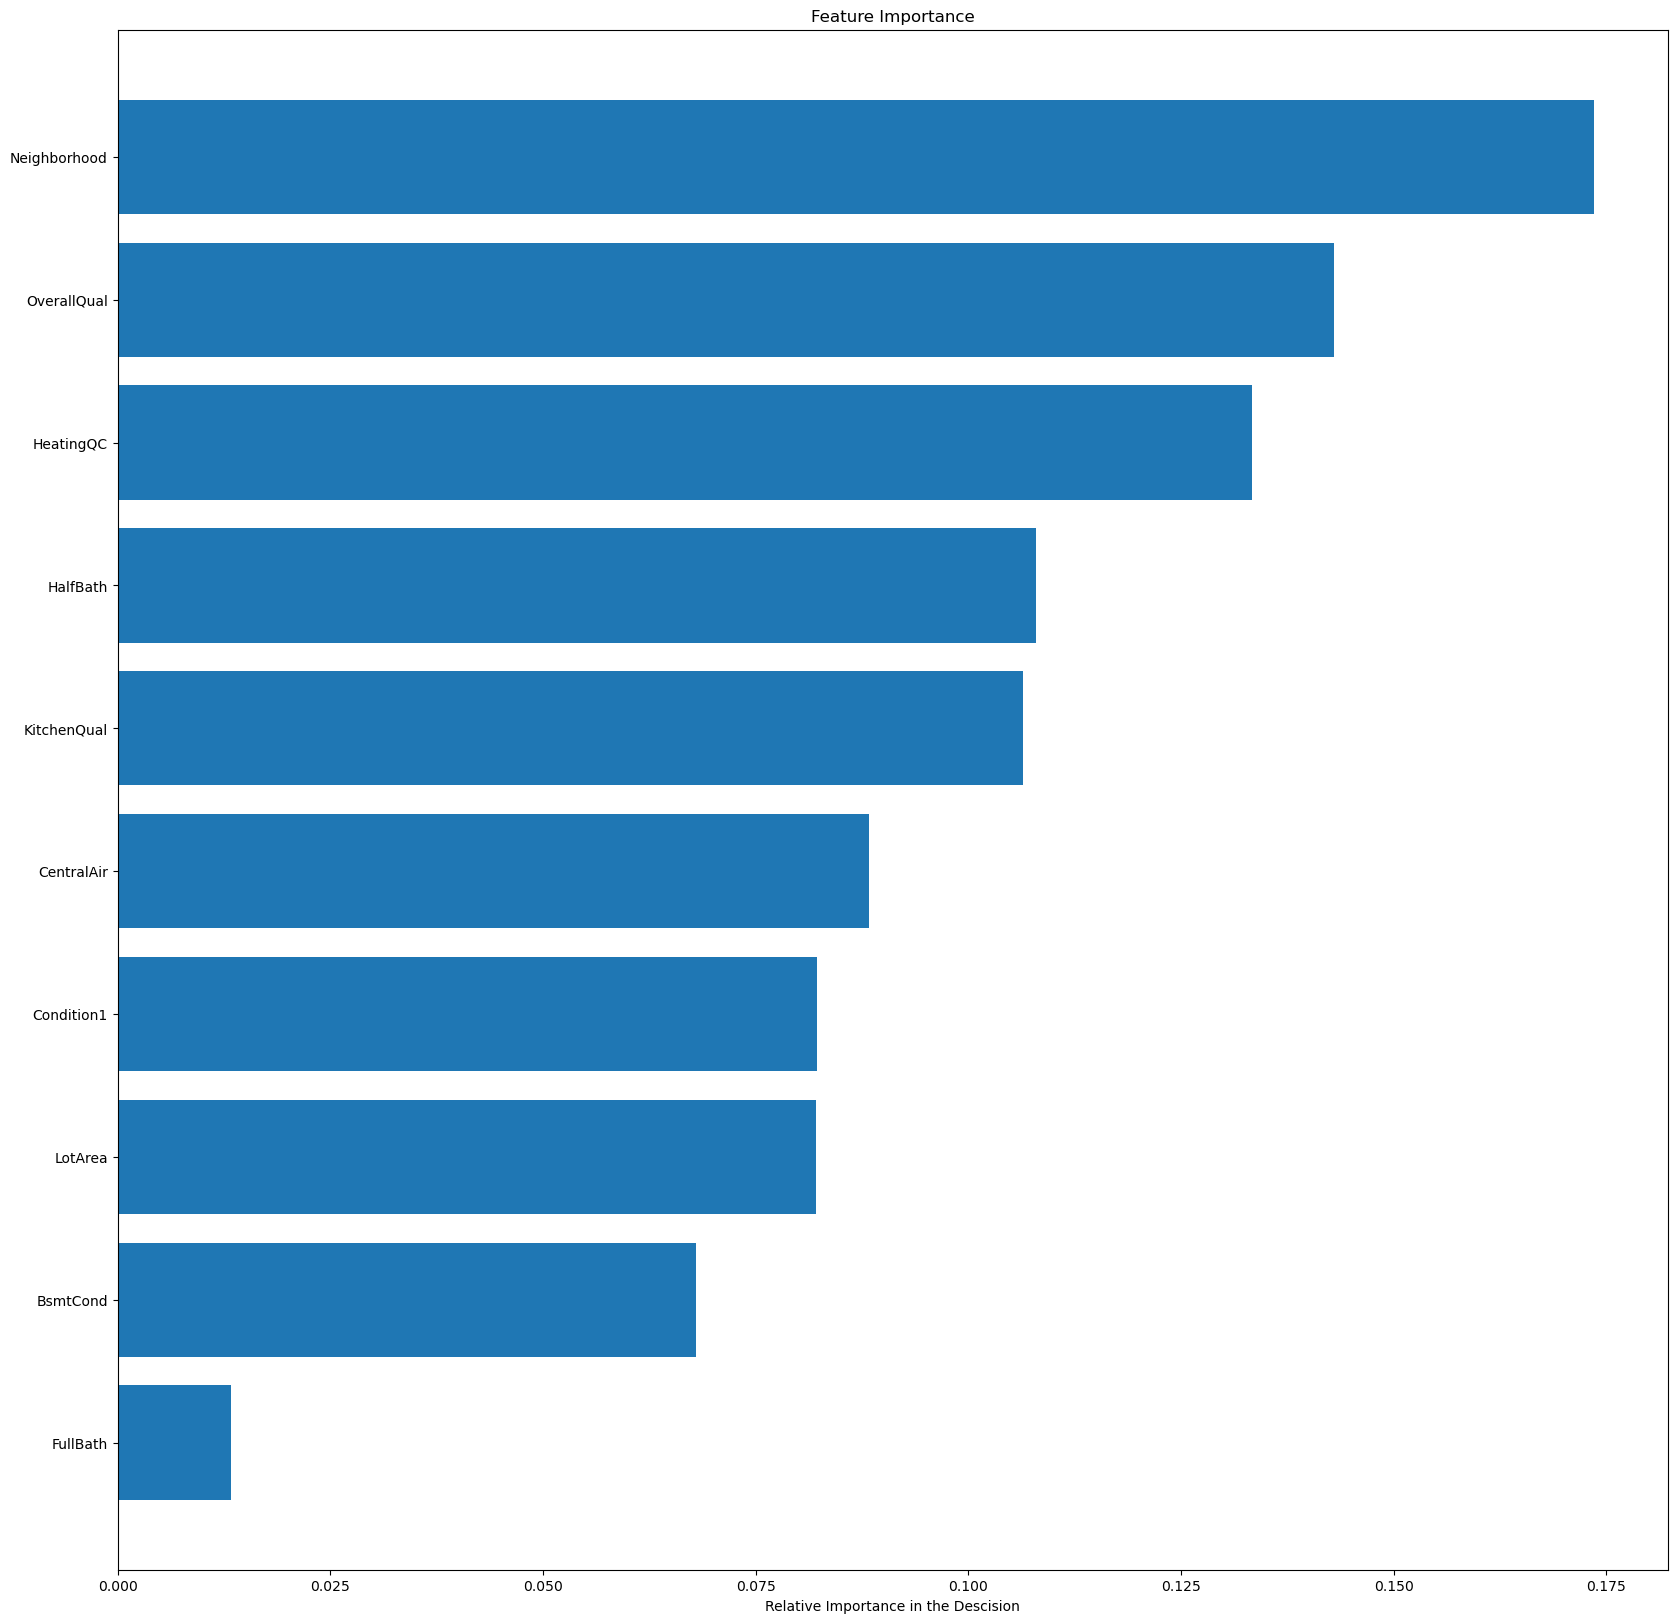

In [569]:
n_most_important = 10

dict_feature_importance = dict(zip(selected_instinct, clf_INST.feature_importances_))
dict_feature_importance = {k: v for k, v in sorted(dict_feature_importance.items(), key=lambda item: item[1], reverse=True)}

fig, ax = plt.subplots()

y_pos = np.arange(len(selected))

ax.barh(y_pos[:n_most_important], list(dict_feature_importance.values())[:n_most_important], align='center')
ax.set_yticks(y_pos[:n_most_important])
ax.set_yticklabels(list(dict_feature_importance.keys())[:n_most_important])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Relative Importance in the Descision')
ax.set_title('Feature Importance')

plt.show()

In [580]:
print("R2 score: {:.2f}".format(r2_score(y_validINST.flatten(), clf_INST.predict(X_validINST).flatten())))

R2 score: 0.90


The final performance of the model are: 
- **R2: 0.90**
- **RMSE: 22181**  

Model has strong performances on the 26 selected features. A similar feature selection was applied to SF, however, due to the limited number of predictors that one can use in, only the following features were selected: 
"MSSubClass", 
"Neighborhood", 
 "Condition1",                  
 "OverallQual", 
 "YearRemodAdd", 
 "HeatingQC", 
 "GrLivArea", 
 "FullBath", 
 "BedroomAbvGr", 
 "KitchenQual", 
 "Fireplaces", 
 "GarageCars", 
 "PoolArea". Relying on solely these predictors decreased SF's model's performances: R2 of 0.8 and RMSE of 34k. 